In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 50)
# pd.set_option('display.max_rows', 50)
import tabula
from pandasql import sqldf
import math
from scipy.stats import chi2
from scipy import stats
from matplotlib import pyplot as plt

---------RNA-------------

In [2]:
# integrated dataset
rna_layer = pd.read_excel(r'C:\Users\edwar\Desktop\農藝\paper2\metaData_soybean_drought.xlsx', sheet_name = 'RNA')


# prince_2015 no need preprocessing
prince_2015 = pd.read_excel(r'C:\Users\edwar\Desktop\農藝\paper2\data collection\whole genome data\incomplete\gene expression\Prince-2015\Prince2015_iwgd.xlsx')

# no need preprocesing (non-omics)
sinha_2023 = pd.read_excel(r'C:\Users\edwar\Desktop\農藝\paper2\data collection\whole genome data\incomplete\gene expression\Sinha-2023\Sinha2023_iwgd.xlsx')

# no need preprocessing
maru_2012 = pd.read_excel(r'C:\Users\edwar\Desktop\農藝\paper2\data collection\whole genome data\incomplete\noncoding\Maruyama-2012\Maruyama2012_iwgd.xlsx')
maru_2012['fc'] = np.nan  # 因為 fc 資料不漂亮所以這樣設置讓他進入 p data 的分類

In [3]:
rna_layer = pd.concat([rna_layer, prince_2015, sinha_2023, maru_2012]).reset_index().drop(['index'], axis = 1)

In [4]:
# import gene_version
glyma_gene_ver = pd.read_csv(r'C:\Users\edwar\Desktop\農藝\paper2\Glyma_genes_correspondence_final.txt', delimiter = '\t')

In [5]:
# 把 fc < 1 的換成倒數
rna_layer.loc[(rna_layer['fc'] < 1), 'fc'] = 1 / rna_layer['fc']

In [6]:
gene_data_p = rna_layer[(rna_layer['p'].isna() == False) & (rna_layer['fc'].isna()) & (rna_layer['rehydration_time'].isna())].reset_index().drop(['index'], axis = 1)[['methodology', 'mapped_gene', 'p', 'fc', 'drought_treatment_span', 'gene_version', 'article_name']]
gene_data_fc = rna_layer[(rna_layer['p'].isna()) & (rna_layer['fc'].isna() == False) & (rna_layer['rehydration_time'].isna())].reset_index().drop(['index'], axis = 1)[['methodology', 'mapped_gene', 'p', 'fc', 'drought_treatment_span', 'gene_version', 'article_name']]
gene_data_pfc = rna_layer[(rna_layer['p'].isna() == False) & (rna_layer['fc'].isna() == False) & (rna_layer['rehydration_time'].isna())].reset_index().drop(['index'], axis = 1)[['methodology', 'mapped_gene', 'p', 'fc', 'drought_treatment_span', 'gene_version', 'article_name']]

In [7]:
# p 資料的 gene version 轉換
gene_data_p_v2 = gene_data_p[gene_data_p['gene_version'] == 2].reset_index().drop(['index'], axis = 1)
gene_data_p_v1 = gene_data_p[gene_data_p['gene_version'] == 1].reset_index().drop(['index'], axis = 1)

gene_data_p_v2 = gene_data_p_v2.rename(columns = {'mapped_gene':'gene_org'})
gene_data_p_v1 = gene_data_p_v1.rename(columns = {'mapped_gene':'gene_org'})

gene_data_p_v2['gene'] = gene_data_p_v2['gene_org']
gene_data_p_v1 = gene_data_p_v1.merge(glyma_gene_ver[['Wm82.a1.v1', 'Wm82.a2.v1']], how = 'left', left_on = ['gene_org'], right_on = ['Wm82.a1.v1']).drop(['Wm82.a1.v1'], axis = 1).rename(columns = {'Wm82.a2.v1':'gene'})

In [8]:
# 刪除沒有對應到的
gene_data_p_v1 = gene_data_p_v1[gene_data_p_v1['gene'].isna() == False].reset_index().drop(['index'], axis = 1)
gene_data_p_v2 = gene_data_p_v2[gene_data_p_v2['gene'].isna() == False].reset_index().drop(['index'], axis = 1)
gene_data_p = pd.concat([gene_data_p_v1, gene_data_p_v2]).reset_index().drop(['index'], axis = 1)

In [9]:
# fc 資料的 gene version 轉換
gene_data_fc_v1 = gene_data_fc[gene_data_fc['gene_version'] == 1].reset_index().drop(['index'], axis = 1)
gene_data_fc_v2 = gene_data_fc[gene_data_fc['gene_version'] == 2].reset_index().drop(['index'], axis = 1)
gene_data_fc_nan = gene_data_fc[gene_data_fc['gene_version'] == np.nan].reset_index().drop(['index'], axis = 1)

gene_data_fc_v2 = gene_data_fc_v2.rename(columns = {'mapped_gene':'gene_org'})
gene_data_fc_v1 = gene_data_fc_v1.rename(columns = {'mapped_gene':'gene_org'})
gene_data_fc_nan = gene_data_fc_nan.rename(columns = {'mapped_gene':'gene_org'})

gene_data_fc_v2['gene'] = gene_data_fc_v2['gene_org']
gene_data_fc_nan['gene'] = gene_data_fc_nan['gene_org']
gene_data_fc_v1 = gene_data_fc_v1.merge(glyma_gene_ver[['Wm82.a1.v1', 'Wm82.a2.v1']], how = 'left', left_on = ['gene_org'], right_on = ['Wm82.a1.v1']).drop(['Wm82.a1.v1'], axis = 1).rename(columns = {'Wm82.a2.v1':'gene'})

In [10]:
# 刪除沒有對應到的
gene_data_fc_v1 = gene_data_fc_v1[gene_data_fc_v1['gene'].isna() == False].reset_index().drop(['index'], axis = 1)
gene_data_fc_v2 = gene_data_fc_v2[gene_data_fc_v2['gene'].isna() == False].reset_index().drop(['index'], axis = 1)
gene_data_fc_nan = gene_data_fc_nan[gene_data_fc_nan['gene'].isna() == False].reset_index().drop(['index'], axis = 1)

In [11]:
gene_data_fc = pd.concat([gene_data_fc_v1, gene_data_fc_v2, gene_data_fc_nan]).reset_index().drop(['index'], axis = 1)

In [12]:
# fc & p 資料 gene version 轉換
gene_data_pfc_v1 = gene_data_pfc[gene_data_pfc['gene_version'] == 1].reset_index().drop(['index'], axis = 1)
gene_data_pfc_v2 = gene_data_pfc[gene_data_pfc['gene_version'] == 2].reset_index().drop(['index'], axis = 1)

gene_data_pfc_v2 = gene_data_pfc_v2.rename(columns = {'mapped_gene':'gene_org'})
gene_data_pfc_v1 = gene_data_pfc_v1.rename(columns = {'mapped_gene':'gene_org'})

gene_data_pfc_v2['gene'] = gene_data_pfc_v2['gene_org']
gene_data_pfc_v1 = gene_data_pfc_v1.merge(glyma_gene_ver[['Wm82.a1.v1', 'Wm82.a2.v1']], how = 'left', left_on = ['gene_org'], right_on = ['Wm82.a1.v1']).drop(['Wm82.a1.v1'], axis = 1).rename(columns = {'Wm82.a2.v1':'gene'})

In [13]:
gene_data_pfc_v1 = gene_data_pfc_v1[gene_data_pfc_v1['gene'].isna() == False].reset_index().drop(['index'], axis = 1)
gene_data_pfc_v2 = gene_data_pfc_v2[gene_data_pfc_v2['gene'].isna() == False].reset_index().drop(['index'], axis = 1)

In [14]:
gene_data_pfc = pd.concat([gene_data_pfc_v1, gene_data_pfc_v2]).reset_index().drop(['index'], axis = 1)

In [15]:
gene_data_p = gene_data_p[['methodology', 'gene', 'p', 'fc', 'drought_treatment_span', 'article_name', 'gene_org']]
gene_data_fc = gene_data_fc[['methodology', 'gene', 'p', 'fc', 'drought_treatment_span', 'article_name', 'gene_org']]
gene_data_pfc = gene_data_pfc[['methodology', 'gene', 'p', 'fc', 'drought_treatment_span', 'article_name', 'gene_org']]

In [16]:
# data scaling function
def scale_score(x, upper_b, lower_b, max_val, min_val):
    scaling = (upper_b - lower_b) / (max_val - min_val)
    return (x - min_val) * scaling + lower_b

In [17]:
# 處理 p 資料
article_list = list(gene_data_p['article_name'].unique())
extreme_art_lst = list(gene_data_p[gene_data_p['p'] < 10 ** -80]['article_name'].unique())
gene_score_data_p = pd.DataFrame()

count = 0
for article in article_list:
    if article == extreme_art_lst[0]:
        df = gene_data_p[gene_data_p['article_name'] == article].reset_index().drop(['index'], axis = 1)
        df.loc[(df['p'] < 10 ** -269), 'p'] = 10 ** -270
        df['-logp'] = -np.log10(df['p'])
        upper_b = 80
        lower_b = 3.3  # 最小 p 轉換後約 3.39
        max_val = df['-logp'].max()
        min_val = df['-logp'].min()
        df['trans_logp'] = df['-logp'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))
        df['p'] = 10 ** -df['trans_logp']
        gene_data_article_p = df.drop(['-logp', 'trans_logp'], axis = 1)
        gene_list = list(gene_data_article_p['gene'].unique())
        
    elif article == extreme_art_lst[1]:
        df = gene_data_p[gene_data_p['article_name'] == article].reset_index().drop(['index'], axis = 1)
        df.loc[(df['p'] < 10 ** -308), 'p'] = 10 ** -309
        df['-logp'] = -np.log10(df['p'])
        upper_b = 80
        lower_b = 1.9  # 最小 -logp 轉換後大約數值
        max_val = df['-logp'].max()
        min_val = df['-logp'].min()
        df['trans_logp'] = df['-logp'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))
        df['p'] = 10 ** -df['trans_logp']
        gene_data_article_p = df.drop(['-logp', 'trans_logp'], axis = 1)
        gene_list = list(gene_data_article_p['gene'].unique())
        
    elif article == extreme_art_lst[2]:
        df = gene_data_p[gene_data_p['article_name'] == article].reset_index().drop(['index'], axis = 1)
        df.loc[(df['p'] < 10 ** -268), 'p'] = 10 ** -269
        df['-logp'] = -np.log10(df['p'])
        upper_b = 70
        lower_b = 2.2  # 最小 -logp 轉換後大約數值
        max_val = df['-logp'].max()
        min_val = df['-logp'].min()
        df['trans_logp'] = df['-logp'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))
        df['p'] = 10 ** -df['trans_logp']
        gene_data_article_p = df.drop(['-logp', 'trans_logp'], axis = 1)
        gene_list = list(gene_data_article_p['gene'].unique())
        
    elif article == extreme_art_lst[3]:
        df = gene_data_p[gene_data_p['article_name'] == article].reset_index().drop(['index'], axis = 1)
        df['-logp'] = -np.log10(df['p'])
        upper_b = 70
        lower_b = 0.7  # 最小 -logp 轉換後大約數值
        max_val = df['-logp'].max()
        min_val = df['-logp'].min()
        df['trans_logp'] = df['-logp'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))
        df['p'] = 10 ** -df['trans_logp']
        gene_data_article_p = df.drop(['-logp', 'trans_logp'], axis = 1)
        gene_list = list(gene_data_article_p['gene'].unique())
        
    else:
        gene_data_article_p = gene_data_p[gene_data_p['article_name'] == article].reset_index().drop(['index'], axis = 1)
        gene_list = list(gene_data_article_p['gene'].unique())
    
    for gene in gene_list:
        df_gene = gene_data_article_p[gene_data_article_p['gene'] == gene].reset_index().drop(['index'], axis = 1)
        if len(df_gene['gene']) > 1:
            df_gene_v1 = pd.DataFrame()
            df_gene_v1['gene'] = df_gene['gene'].unique()
            df_gene_v1['p'] = df_gene['p'].min()
            df_gene_v1['fc'] = np.nan
            df_gene_v1['article_name'] = df_gene['article_name'].unique()
            gene_score_data_p = pd.concat([gene_score_data_p, df_gene_v1]).reset_index().drop(['index'], axis = 1)
            
        elif len(df_gene['gene']) == 1:
            gene_score_data_p = pd.concat([gene_score_data_p, df_gene[['gene', 'p', 'fc', 'article_name']]]).reset_index().drop(['index'], axis = 1)
    count += 1
    if count % 10 == 0:
        print(count)

10
20
30


In [18]:
# 設置門檻
p_thres = 0.05
gene_score_data_p['sig_flag'] = ''
gene_score_data_p['nonsig_flag'] = ''

gene_score_data_p.loc[(gene_score_data_p['p'] < p_thres), 'sig_flag'] = 1
gene_score_data_p.loc[(gene_score_data_p['p'] < p_thres), 'nonsig_flag'] = 0

gene_score_data_p.loc[(gene_score_data_p['p'] >= p_thres), 'nonsig_flag'] = 1
gene_score_data_p.loc[(gene_score_data_p['p'] >= p_thres), 'sig_flag'] = 0

In [19]:
# 整合 p data
gene_list = list(gene_score_data_p['gene'].unique())
gene_score_data_p_v1 = pd.DataFrame()

count = 0
for gene in gene_list:
    df_gene = gene_score_data_p[gene_score_data_p['gene'] == gene].reset_index().drop(['index'], axis = 1)
    if len(df_gene['gene']) > 1:
        df_gene_v1 = pd.DataFrame()
        p_values = list(df_gene['p'])
        p_value = stats.combine_pvalues(p_values, method = 'fisher')[1]
        df_gene_v1['gene'] = df_gene['gene'].unique()
        df_gene_v1['p'] = p_value
        df_gene_v1['fc'] = np.nan
        df_gene_v1['sig_flag'] = df_gene['sig_flag'].sum()
        df_gene_v1['nonsig_flag'] = df_gene['nonsig_flag'].sum()
        gene_score_data_p_v1 = pd.concat([gene_score_data_p_v1, df_gene_v1]).reset_index().drop(['index'], axis = 1)
    
    elif len(df_gene['gene']) == 1:
        gene_score_data_p_v1 = pd.concat([gene_score_data_p_v1, df_gene[['gene', 'p', 'fc', 'sig_flag', 'nonsig_flag']]]).reset_index().drop(['index'], axis = 1)
    
    count += 1
    if count % 1000 == 0:
        print(count)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [20]:
gene_score_data_p_v1.head()

,gene,p,fc,sig_flag,nonsig_flag
0,Glyma.05g039900,0.000008,NaN,2,0
1,Glyma.11g131900,0.000215,NaN,1,0
2,Glyma.13g322100,0.000328,NaN,1,0
3,Glyma.05g123700,0.000302,NaN,1,0
4,Glyma.09g163300,0.000163,NaN,1,0


In [21]:
# 把 fc 設一個最大上限
gene_data_fc.loc[(gene_data_fc['fc'] > 480), 'fc'] = 480

In [22]:
# 處理 fc 資料
article_list = list(gene_data_fc['article_name'].unique())
gene_score_data_fc = pd.DataFrame()

count = 0
for article in article_list:
    gene_data_article_fc = gene_data_fc[gene_data_fc['article_name'] == article].reset_index().drop(['index'], axis = 1)
    gene_list = list(gene_data_article_fc['gene'].unique())
    
    for gene in gene_list:
        df_gene = gene_data_article_fc[gene_data_article_fc['gene'] == gene].reset_index().drop(['index'], axis = 1)
        df_gene_v1 = pd.DataFrame()
        df_gene_v1['gene'] = df_gene['gene'].unique()
        df_gene_v1['fc'] = df_gene['fc'].max()
        df_gene_v1['p'] = ''
        df_gene_v1['article_name'] = df_gene['article_name'].unique()
        gene_score_data_fc = pd.concat([gene_score_data_fc, df_gene_v1]).reset_index().drop(['index'], axis = 1)  
    
    count += 1
    if count % 10 == 0:
        print(count)

10
20
30
40
50
60
70
80
90
100
110


In [23]:
gene_score_data_fc['p'] = 0.1 ** np.log2(gene_score_data_fc['fc'])

In [24]:
# 設置門檻
tranP_thres = 0.05
gene_score_data_fc['sig_flag'] = ''
gene_score_data_fc['nonsig_flag'] = ''

gene_score_data_fc.loc[(gene_score_data_fc['p'] < tranP_thres), 'sig_flag'] = 1
gene_score_data_fc.loc[(gene_score_data_fc['p'] < tranP_thres), 'nonsig_flag'] = 0

gene_score_data_fc.loc[(gene_score_data_fc['p'] >= tranP_thres), 'nonsig_flag'] = 1
gene_score_data_fc.loc[(gene_score_data_fc['p'] >= tranP_thres), 'sig_flag'] = 0

In [25]:
gene_list = list(gene_score_data_fc['gene'].unique())
gene_score_data_fc_v1 = pd.DataFrame()

for gene in gene_list:
    df_gene = gene_score_data_fc[gene_score_data_fc['gene'] == gene].reset_index().drop(['index'], axis = 1)
    if len(df_gene['gene']) > 1:
        df_gene_v1 = pd.DataFrame()
        p_values = list(df_gene['p'])
        p_value = stats.combine_pvalues(p_values, method = 'fisher')[1]
        df_gene_v1['gene'] = df_gene['gene'].unique()
        df_gene_v1['p'] = p_value
        df_gene_v1['fc'] = np.nan
        df_gene_v1['sig_flag'] = df_gene['sig_flag'].sum()
        df_gene_v1['nonsig_flag'] = df_gene['nonsig_flag'].sum()
        gene_score_data_fc_v1 = pd.concat([gene_score_data_fc_v1, df_gene_v1]).reset_index().drop(['index'], axis = 1)
        
    elif len(df_gene['gene']) == 1:
        gene_score_data_fc_v1 = pd.concat([gene_score_data_fc_v1, df_gene[['gene', 'p', 'fc', 'sig_flag', 'nonsig_flag']]]).reset_index().drop(['index'], axis = 1)
    
    count += 1
    if count % 500 == 0:
        print(count)

500
1000
1500


In [26]:
gene_score_data_fc_v1.loc[(gene_score_data_fc_v1['p'] < 10 ** -9), 'p'] = 10 ** -9

In [27]:
gene_score_data_fc_v1.head()

,gene,p,fc,sig_flag,nonsig_flag
0,Glyma.01g166100,0.000199,NaN,1,1
1,Glyma.02g182900,0.001276,NaN,1,1
2,Glyma.02g192700,0.000003,NaN,2,0
3,Glyma.02g278900,0.047651,2.5,1,0
4,Glyma.03g204100,0.000370,NaN,1,1


In [28]:
# 設置 FC 上限
gene_data_pfc.loc[(gene_data_pfc['fc'] > 300), 'fc'] = 300

In [29]:
article_list = list(gene_data_pfc['article_name'].unique())
gene_score_data_pfc = pd.DataFrame()

count = 0
for article in article_list:
    gene_data_article_pfc = gene_data_pfc[gene_data_pfc['article_name'] == article].reset_index().drop(['index'], axis = 1)
    gene_list = list(gene_data_article_pfc['gene'].unique())
    
    for gene in gene_list:
        df_gene = gene_data_article_pfc[gene_data_article_pfc['gene'] == gene].reset_index().drop(['index'], axis = 1)
        if len(df_gene['gene']) > 1:
            df_gene_v1 = pd.DataFrame()
            p_values = list(df_gene['p'])
            p_value = stats.combine_pvalues(p_values, method = 'fisher')[1]
            df_gene_v1['gene'] = df_gene['gene'].unique()
            df_gene_v1['p'] = p_value
            df_gene_v1['fc'] = df_gene['fc'].max()
            df_gene_v1['article_name'] = df_gene['article_name'].unique()
            gene_score_data_pfc = pd.concat([gene_score_data_pfc, df_gene_v1]).reset_index().drop(['index'], axis = 1)
            
        elif len(df_gene['gene']) == 1:
            gene_score_data_pfc = pd.concat([gene_score_data_pfc, df_gene[['gene', 'p', 'fc', 'article_name']]]).reset_index().drop(['index'], axis = 1)
    
    count += 1
    if count % 2 == 0:
        print(count)

2
4


In [30]:
gene_score_data_pfc['p_new'] = gene_score_data_pfc['p'] ** np.log2(gene_score_data_pfc['fc'])

In [31]:
gene_score_data_pfc.loc[(gene_score_data_pfc['p_new'] < 10 ** -24), 'p_new'] = 10 ** -24

In [32]:
gene_score_data_pfc = gene_score_data_pfc.drop(['p'], axis = 1).rename(columns = {'p_new':'p'})[['gene', 'p', 'fc', 'article_name']]

In [33]:
pfc_thres = 0.05
gene_score_data_pfc['sig_flag'] = ''
gene_score_data_pfc['nonsig_flag'] = ''

gene_score_data_pfc.loc[(gene_score_data_pfc['p'] < pfc_thres), 'sig_flag'] = 1
gene_score_data_pfc.loc[(gene_score_data_pfc['p'] < pfc_thres), 'nonsig_flag'] = 0

gene_score_data_pfc.loc[(gene_score_data_pfc['p'] >= pfc_thres), 'nonsig_flag'] = 1
gene_score_data_pfc.loc[(gene_score_data_pfc['p'] >= pfc_thres), 'sig_flag'] = 0

In [34]:
gene_list = list(gene_score_data_pfc['gene'].unique())
gene_score_data_pfc_v1 = pd.DataFrame()

for gene in gene_list:
    df_gene = gene_score_data_pfc[gene_score_data_pfc['gene'] == gene].reset_index().drop(['index'], axis = 1)
    if len(df_gene['gene']) > 1:
        df_gene_v1 = pd.DataFrame()
        p_values = list(df_gene['p'])
        p_value = stats.combine_pvalues(p_values, method = 'fisher')[1]
        df_gene_v1['gene'] = df_gene['gene'].unique()
        df_gene_v1['p'] = p_value ** np.log2(df_gene['fc'].mean())
        df_gene_v1['fc'] = df_gene['fc'].mean()
        df_gene_v1['sig_flag'] = df_gene['sig_flag'].sum()
        df_gene_v1['nonsig_flag'] = df_gene['nonsig_flag'].sum()
        gene_score_data_pfc_v1 = pd.concat([gene_score_data_pfc_v1, df_gene_v1]).reset_index().drop(['index'], axis = 1)
        
    elif len(df_gene['gene']) == 1:
        gene_score_data_pfc_v1 = pd.concat([gene_score_data_pfc_v1, df_gene[['gene', 'p', 'fc', 'sig_flag', 'nonsig_flag']]]).reset_index().drop(['index'], axis = 1)
    
    count += 1
    if count % 500 == 0:
        print(count)

500
1000
1500
2000


In [35]:
gene_score_data_pfc_v1.loc[(gene_score_data_pfc_v1['p'] < 10 ** -25), 'p'] = 10 ** -25

In [36]:
gene_score_data_pfc_v1.head()

,gene,p,fc,sig_flag,nonsig_flag
0,Glyma.11g120300,7.006070e-08,8.130081,1,0
1,Glyma.08g324900,1.338694e-11,4.761905,1,0
2,Glyma.04g000400,2.123232e-02,1.785714,1,0
3,Glyma.04g202900,5.715092e-02,1.538462,0,1
4,Glyma.09g248600,5.155700e-04,3.125000,1,0


In [37]:
def scale_score(x, upper_b, lower_b, max_val, min_val):
    scaling = (upper_b - lower_b) / (max_val - min_val)
    return (x - min_val) * scaling + lower_b

In [38]:
# 把 p, fc, pfc 的 data 中的 p值轉換成 -logp，然後 scale 到 [0, 10]，然後轉回新的 p，之後再把三個 data 合併
gene_score_data_p_v1['-logp'] = -np.log10(gene_score_data_p_v1['p'])
gene_score_data_fc_v1['-logp'] = -np.log10(gene_score_data_fc_v1['p'])
gene_score_data_pfc_v1['-logp'] = -np.log10(gene_score_data_pfc_v1['p'])

In [39]:
# p data
upper_b = 10
lower_b = 0
max_val = gene_score_data_p_v1['-logp'].max()
min_val = 0

gene_score_data_p_v1['score_raw'] = gene_score_data_p_v1['-logp'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [40]:
# fc data
upper_b = 10
lower_b = 0
max_val = gene_score_data_fc_v1['-logp'].max()
min_val = 0

gene_score_data_fc_v1['score_raw'] = gene_score_data_fc_v1['-logp'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [41]:
# p & fc data
upper_b = 10
lower_b = 0
max_val = gene_score_data_pfc_v1['-logp'].max()
min_val = 0

gene_score_data_pfc_v1['score_raw'] = gene_score_data_pfc_v1['-logp'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [42]:
gene_score_data = pd.concat([gene_score_data_p_v1, gene_score_data_fc_v1, gene_score_data_pfc_v1]).reset_index().drop(['index'], axis = 1)

In [43]:
gene_score_data['p_v1'] = 10 ** -gene_score_data['score_raw']

In [44]:
gene_list = list(gene_score_data['gene'].unique())
gene_score_data_v1 = pd.DataFrame()

count = 0
for gene in gene_list:
    df_gene = gene_score_data[gene_score_data['gene'] == gene].reset_index().drop(['index'], axis = 1)
    if len(df_gene['gene']) > 1:
        df_gene_v1 = pd.DataFrame()
        p_values = list(df_gene['p_v1'])
        p_value = stats.combine_pvalues(p_values, method = 'fisher')[1]
        df_gene_v1['gene'] = df_gene['gene'].unique()
        df_gene_v1['p'] = p_value
        df_gene_v1['sig_flag'] = df_gene['sig_flag'].sum()
        df_gene_v1['nonsig_flag'] = df_gene['nonsig_flag'].sum()
        gene_score_data_v1 = pd.concat([gene_score_data_v1, df_gene_v1]).reset_index().drop(['index'], axis = 1)
        
    elif len(df_gene['gene']) == 1:
        gene_score_data_v1 = pd.concat([gene_score_data_v1, df_gene[['gene', 'p_v1', 'sig_flag', 'nonsig_flag']].rename(columns = {'p_v1':'p'})]).reset_index().drop(['index'], axis = 1)
    
    count += 1
    if count % 1000 == 0:
        print(count)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000


In [45]:
gene_score_data_v1['-logp'] = -np.log10(gene_score_data_v1['p'])
upper_b = 6
lower_b = 0
max_val = gene_score_data_v1['-logp'].max()
min_val = 0
gene_score_data_v1['score'] = gene_score_data_v1['-logp'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

(array([9.766e+03, 1.669e+03, 4.810e+02, 1.860e+02, 1.030e+02, 4.500e+01,
        1.100e+01, 8.000e+00, 1.000e+00, 1.000e+00]),
 array([5.83414038e-03, 6.05250726e-01, 1.20466731e+00, 1.80408390e+00,
        2.40350048e+00, 3.00291707e+00, 3.60233366e+00, 4.20175024e+00,
        4.80116683e+00, 5.40058341e+00, 6.00000000e+00]),
 <BarContainer object of 10 artists>)

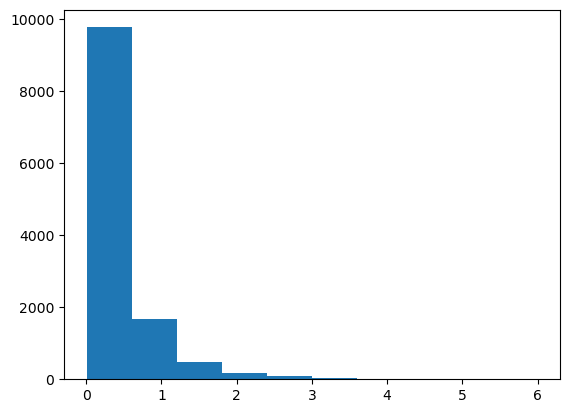

In [46]:
plt.hist(gene_score_data_v1['score'])

incomplete whole genome: re-scaling the score of genes to [0, 6]

In [47]:
# incomplete whole genome data
# kim_2020
kim_2020 = pd.read_excel(r'C:\Users\edwar\Desktop\農藝\paper2\data collection\whole genome data\incomplete\gene expression\Kim-2020\Kim2020_iwgd.xlsx')
kim_2020.loc[(kim_2020['fc'] < 1), 'fc'] = 1 / kim_2020['fc']
kim_2020.loc[(kim_2020['fc'] > 400), 'fc'] = 400

In [48]:
kim_2020_data = kim_2020[['mapped_gene', 'fc']]
gene_list = list(kim_2020_data['mapped_gene'].unique())
kim_2020_data_v1 = pd.DataFrame()

count = 0
for gene in gene_list:
    df_gene = kim_2020_data[kim_2020_data['mapped_gene'] == gene].reset_index().drop(['index'], axis = 1)
    df_gene_v1 = pd.DataFrame()
    df_gene_v1['gene'] = df_gene['mapped_gene'].unique()
    df_gene_v1['fc'] = df_gene['fc'].max()
    kim_2020_data_v1 = pd.concat([kim_2020_data_v1, df_gene_v1]).reset_index().drop(['index'], axis = 1)
    count += 1
    if count % 1000 == 0:
        print(count)

1000
2000
3000
4000


In [49]:
kim_2020_data_v1['p_val'] = 0.1 ** np.log2(kim_2020_data_v1['fc'])
kim_2020_data_v1['score_raw'] = -np.log10(kim_2020_data_v1['p_val'])
kim_2020_data_v1['sig_flag'] = ''
kim_2020_data_v1['nonsig_flag'] = ''
kim_2020_data_v1.loc[(kim_2020_data_v1['p_val'] >= 0.05), 'sig_flag'] = 0
kim_2020_data_v1.loc[(kim_2020_data_v1['p_val'] >= 0.05), 'nonsig_flag'] = 1
kim_2020_data_v1.loc[(kim_2020_data_v1['p_val'] < 0.05), 'sig_flag'] = 1
kim_2020_data_v1.loc[(kim_2020_data_v1['p_val'] < 0.05), 'nonsig_flag'] = 0

In [50]:
upper_b = 6
lower_b = 0
max_val = kim_2020_data_v1['score_raw'].max()
min_val = 0
kim_2020_data_v1['score'] = kim_2020_data_v1['score_raw'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

(array([1978.,  957.,  515.,  243.,  172.,   72.,   53.,   33.,   22.,
          53.]),
 array([1.38826928, 1.84944235, 2.31061542, 2.7717885 , 3.23296157,
        3.69413464, 4.15530771, 4.61648078, 5.07765386, 5.53882693,
        6.        ]),
 <BarContainer object of 10 artists>)

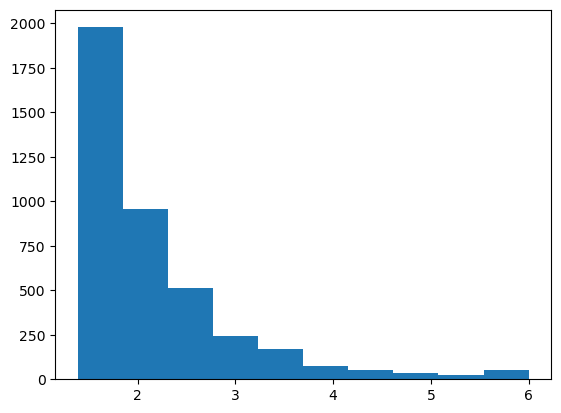

In [51]:
plt.hist(kim_2020_data_v1['score'])

In [52]:
kim_2020_data_v1.head()

,gene,fc,p_val,score_raw,sig_flag,nonsig_flag,score
0,Glyma.15g209800,26.741343,0.000018,4.741,1,0,3.290892
1,Glyma.19g200200,4.109606,0.009141,2.039,1,0,1.415341
2,Glyma.19g199300,5.108855,0.004436,2.353,1,0,1.633299
3,Glyma.10g262600,7.200015,0.001419,2.848,1,0,1.976895
4,Glyma.11g038600,4.195957,0.008531,2.069,1,0,1.436165


In [53]:
# incomplete whole genome data
# rodrigues_2015
rodrigues_2015 = pd.read_excel(r'C:\Users\edwar\Desktop\農藝\paper2\data collection\whole genome data\incomplete\gene expression\Rodrigues-2015\Rodrigues2015_iwgd.xlsx')
rodrigues_2015_data = rodrigues_2015[['mapped_gene', 'p']]
rodrigues_2015_data['-logp'] = -np.log10(rodrigues_2015_data['p'])
rodrigues_2015_data.loc[(rodrigues_2015_data['-logp'] > 32), '-logp'] = 32

C:\Users\edwar\AppData\Local\Temp\ipykernel_10912\1182524733.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rodrigues_2015_data['-logp'] = -np.log10(rodrigues_2015_data['p'])


In [54]:
rodrigues_2015_data['sig_flag'] = ''
rodrigues_2015_data['nonsig_flag'] = ''

rodrigues_2015_data.loc[(rodrigues_2015_data['p'] < 0.05), 'sig_flag'] = 1
rodrigues_2015_data.loc[(rodrigues_2015_data['p'] < 0.05), 'nonsig_flag'] = 0
rodrigues_2015_data.loc[(rodrigues_2015_data['p'] >= 0.05), 'nonsig_flag'] = 1
rodrigues_2015_data.loc[(rodrigues_2015_data['p'] >= 0.05), 'sig_flag'] = 0

C:\Users\edwar\AppData\Local\Temp\ipykernel_10912\117505275.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rodrigues_2015_data['sig_flag'] = ''
C:\Users\edwar\AppData\Local\Temp\ipykernel_10912\117505275.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rodrigues_2015_data['nonsig_flag'] = ''


In [55]:
upper_b = 6
lower_b = 0
max_val = rodrigues_2015_data['-logp'].max()
min_val = 0
rodrigues_2015_data['score'] = rodrigues_2015_data['-logp'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))
rodrigues_2015_data = rodrigues_2015_data.merge(glyma_gene_ver[['Wm82.a1.v1', 'Wm82.a2.v1']], left_on = ['mapped_gene'], right_on = ['Wm82.a1.v1'], how = 'left').drop(['Wm82.a1.v1'], axis = 1).rename(columns = {'mapped_gene':'gene_org', 'Wm82.a2.v1':'gene'})
rodrigues_2015_data = rodrigues_2015_data[rodrigues_2015_data['gene'].isna() == False].reset_index().drop(['index'], axis = 1)

C:\Users\edwar\AppData\Local\Temp\ipykernel_10912\2520648447.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rodrigues_2015_data['score'] = rodrigues_2015_data['-logp'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))


(array([2324.,  566.,  167.,   67.,   38.,   30.,   18.,    7.,    5.,
          24.]),
 array([0.31881101, 0.88692991, 1.45504881, 2.02316771, 2.59128661,
        3.1594055 , 3.7275244 , 4.2956433 , 4.8637622 , 5.4318811 ,
        6.        ]),
 <BarContainer object of 10 artists>)

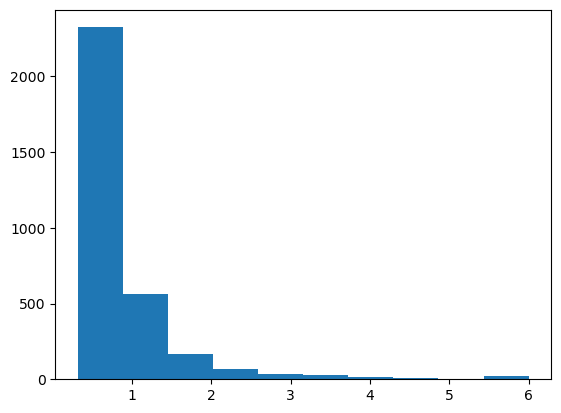

In [56]:
plt.hist(rodrigues_2015_data['score'])

In [57]:
rodrigues_2015_data.head()

,gene_org,p,-logp,sig_flag,nonsig_flag,score,gene
0,Glyma03g12070,1.950000e-04,3.709965,1,0,0.695619,Glyma.03g068100
1,Glyma14g06660,3.470000e-04,3.459671,1,0,0.648688,Glyma.14g061300
2,Glyma05g29630,3.490000e-09,8.457175,1,0,1.585720,Glyma.05g163400
3,Glyma13g24470,1.320000e-02,1.879426,1,0,0.352392,Glyma.13g176100
4,Glyma19g02710,1.895512e-08,7.722273,1,0,1.447926,Glyma.19g023200


In [58]:
# incomplete whole genome data
# tripathi_2016 (有 0.5, 1, 2, 3, 5hr)
tripathi_2016 = pd.read_excel(r'C:\Users\edwar\Desktop\農藝\paper2\data collection\whole genome data\incomplete\gene expression\Tripathi-2016\Tripathi2016_iwgd.xlsx')
tripathi_2016.loc[(tripathi_2016['fc'] < 1), 'fc'] = 1 / tripathi_2016['fc']
# tripathi_2016.loc[(tripathi_2016['fc'] > 270), 'fc'] = 270

In [59]:
tripathi_2016_data = tripathi_2016[['mapped_gene', 'fc']]
tripathi_2016_data.loc[(tripathi_2016_data['fc'] > 250), 'fc'] = 250
gene_list = list(tripathi_2016_data['mapped_gene'].unique())
tripathi_2016_data_v1 = pd.DataFrame()

count = 0
for gene in gene_list:
    df_gene = tripathi_2016_data[tripathi_2016_data['mapped_gene'] == gene].reset_index().drop(['index'], axis = 1)
    df_gene_v1 = pd.DataFrame()
    df_gene_v1['gene'] = df_gene['mapped_gene'].unique()
    df_gene_v1['fc'] = df_gene['fc'].max()
    tripathi_2016_data_v1 = pd.concat([tripathi_2016_data_v1, df_gene_v1]).reset_index().drop(['index'], axis = 1)
    count += 1
    if count % 1000 == 0:
        print(count)

1000
2000
3000
4000


In [60]:
tripathi_2016_data_v1['p_val'] = 0.1 ** np.log2(tripathi_2016_data_v1['fc'])
tripathi_2016_data_v1['score_raw'] = -np.log10(tripathi_2016_data_v1['p_val'])

In [61]:
tripathi_2016_data_v1['sig_flag'] = ''
tripathi_2016_data_v1['nonsig_flag'] = ''
tripathi_2016_data_v1.loc[(tripathi_2016_data_v1['fc'] > 1.5), 'sig_flag'] = 1
tripathi_2016_data_v1.loc[(tripathi_2016_data_v1['fc'] > 1.5), 'nonsig_flag'] = 0
tripathi_2016_data_v1.loc[(tripathi_2016_data_v1['fc'] <= 1.5), 'nonsig_flag'] = 1
tripathi_2016_data_v1.loc[(tripathi_2016_data_v1['fc'] <= 1.5), 'sig_flag'] = 0

In [62]:
upper_b = 6
lower_b = 0
max_val = tripathi_2016_data_v1['fc'].max()
min_val = 0

tripathi_2016_data_v1['score'] = tripathi_2016_data_v1['fc'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))
tripathi_2016_data_v1 = tripathi_2016_data_v1.merge(glyma_gene_ver[['Wm82.a1.v1', 'Wm82.a2.v1']], left_on = ['gene'], right_on = ['Wm82.a1.v1'], how = 'left').drop(['Wm82.a1.v1'], axis = 1).rename(columns = {'gene':'gene_org', 'Wm82.a2.v1':'gene'})
tripathi_2016_data_v1 = tripathi_2016_data_v1[tripathi_2016_data_v1['gene'].isna() == False].reset_index().drop(['index'], axis = 1)

(array([3296.,  355.,   90.,   45.,   27.,   19.,    9.,    7.,    6.,
          28.]),
 array([0.02529379, 0.62276442, 1.22023504, 1.81770566, 2.41517628,
        3.0126469 , 3.61011752, 4.20758814, 4.80505876, 5.40252938,
        6.        ]),
 <BarContainer object of 10 artists>)

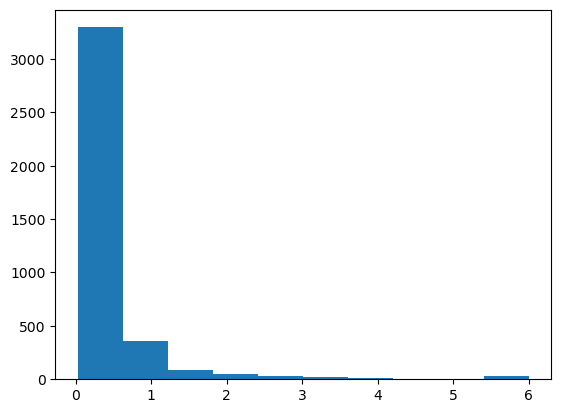

In [63]:
plt.hist(tripathi_2016_data_v1['score'])

In [64]:
tripathi_2016_data_v1.head()

,gene_org,fc,p_val,score_raw,sig_flag,nonsig_flag,score,gene
0,Glyma12g12190,28.753647,0.000014,4.845673,1,0,0.690088,Glyma.12g109600
1,Glyma12g22950,1.100000,0.728612,0.137504,0,1,0.026400,Glyma.12g149500
2,Glyma02g37610,1.610000,0.205560,0.687061,1,0,0.038640,Glyma.02g213000
3,Glyma10g01420,2.610000,0.041300,1.384050,1,0,0.062640,Glyma.10g011000
4,Glyma13g30680,2.179791,0.075129,1.124190,1,0,0.052315,Glyma.13g233600


In [65]:
# incomplete whole genome data
# wang_2021
wang_2021 = pd.read_excel(r'C:\Users\edwar\Desktop\農藝\paper2\data collection\whole genome data\incomplete\gene expression\Wang-2021\Wang2021_iwgd.xlsx')
# wang_2021.loc[(wang_2021['p'] < 10 ** -323), 'p'] = 10 ** -323  # 會有快 500 個基因是 10 ** -323

In [66]:
wang_2021_data = wang_2021[['mapped_gene', 'p']]
wang_2021_data['sig_flag'] = ''
wang_2021_data['nonsig_flag'] = ''
wang_2021_data.loc[(wang_2021_data['p'] < 0.05), 'sig_flag'] = 1
wang_2021_data.loc[(wang_2021_data['p'] < 0.05), 'nonsig_flag'] = 0
wang_2021_data.loc[(wang_2021_data['p'] >= 0.05), 'nonsig_flag'] = 1
wang_2021_data.loc[(wang_2021_data['p'] >= 0.05), 'sig_flag'] = 0

C:\Users\edwar\AppData\Local\Temp\ipykernel_10912\2667600471.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wang_2021_data['sig_flag'] = ''
C:\Users\edwar\AppData\Local\Temp\ipykernel_10912\2667600471.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wang_2021_data['nonsig_flag'] = ''


In [67]:
wang_2021_data.loc[(wang_2021_data['p'] < 10 ** -323), 'p'] = 10 ** -323
wang_2021_data['-logp'] = -np.log10(wang_2021_data['p'])

C:\Users\edwar\AppData\Local\Temp\ipykernel_10912\3065072560.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wang_2021_data['-logp'] = -np.log10(wang_2021_data['p'])


In [68]:
upper_b = 6
lower_b = 0
max_val = wang_2021_data['-logp'].max()
min_val = 0

wang_2021_data['score'] = wang_2021_data['-logp'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

C:\Users\edwar\AppData\Local\Temp\ipykernel_10912\3264094070.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wang_2021_data['score'] = wang_2021_data['-logp'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))


In [69]:
wang_2021_data.head()

,mapped_gene,p,sig_flag,nonsig_flag,-logp,score
0,Glyma.01g013900,9.881313e-324,1,0,323.005185,6.0
1,Glyma.01g017000,9.881313e-324,1,0,323.005185,6.0
2,Glyma.01g019200,9.881313e-324,1,0,323.005185,6.0
3,Glyma.01g025600,9.881313e-324,1,0,323.005185,6.0
4,Glyma.01g031500,9.881313e-324,1,0,323.005185,6.0


(array([11021.,  2642.,  1340.,   734.,   429.,   264.,   179.,   165.,
          114.,   526.]),
 array([0.02764123, 0.62487711, 1.22211298, 1.81934886, 2.41658474,
        3.01382061, 3.61105649, 4.20829237, 4.80552825, 5.40276412,
        6.        ]),
 <BarContainer object of 10 artists>)

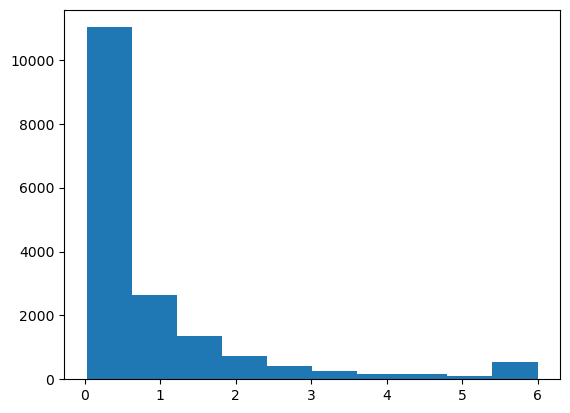

In [70]:
plt.hist(wang_2021_data['score'])

In [71]:
# incomplete whole genome data
# xuan_2022
xuan_2022 = pd.read_excel(r'C:\Users\edwar\Desktop\農藝\paper2\data collection\whole genome data\incomplete\gene expression\Xuan-2022\Xuan2022_iwgd.xlsx')
# xuan_2022_test.loc[(xuan_2022_test['p'] < 10 ** -30), 'p'] = 10 ** -30

In [72]:
xuan_2022_data = xuan_2022[['mapped_gene', 'p']]
xuan_2022_data['-logp'] = -np.log10(xuan_2022_data['p'])
xuan_2022_data.loc[(xuan_2022_data['-logp'] > 40), '-logp'] = 40

C:\Users\edwar\AppData\Local\Temp\ipykernel_10912\712804230.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xuan_2022_data['-logp'] = -np.log10(xuan_2022_data['p'])


In [73]:
xuan_2022_data['sig_flag'] = ''
xuan_2022_data['nonsig_flag'] = ''

xuan_2022_data.loc[(xuan_2022_data['p'] < 0.05), 'sig_flag'] = 1
xuan_2022_data.loc[(xuan_2022_data['p'] < 0.05), 'nonsig_flag'] = 0
xuan_2022_data.loc[(xuan_2022_data['p'] >= 0.05), 'sig_flag'] = 0
xuan_2022_data.loc[(xuan_2022_data['p'] >= 0.05), 'nonsig_flag'] = 1

C:\Users\edwar\AppData\Local\Temp\ipykernel_10912\3029467643.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xuan_2022_data['sig_flag'] = ''
C:\Users\edwar\AppData\Local\Temp\ipykernel_10912\3029467643.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xuan_2022_data['nonsig_flag'] = ''


In [74]:
upper_b = 6
lower_b = 0
max_val = xuan_2022_data['-logp'].max()
min_val = 0

xuan_2022_data['score'] = xuan_2022_data['-logp'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

C:\Users\edwar\AppData\Local\Temp\ipykernel_10912\464144031.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xuan_2022_data['score'] = xuan_2022_data['-logp'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))


(array([3.356e+03, 4.740e+02, 1.310e+02, 7.600e+01, 2.800e+01, 1.600e+01,
        1.300e+01, 6.000e+00, 3.000e+00, 9.000e+00]),
 array([0.19520654, 0.77568589, 1.35616524, 1.93664458, 2.51712393,
        3.09760327, 3.67808262, 4.25856196, 4.83904131, 5.41952065,
        6.        ]),
 <BarContainer object of 10 artists>)

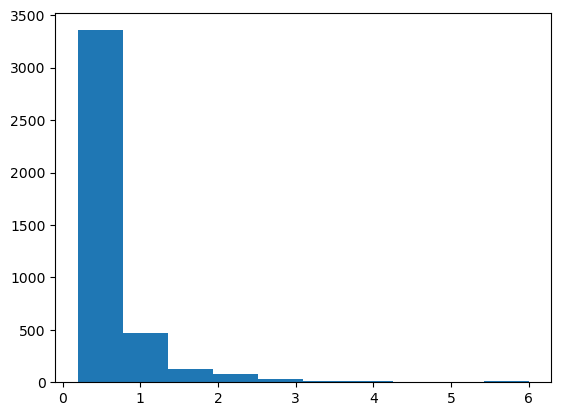

In [75]:
plt.hist(xuan_2022_data['score'])

In [76]:
xuan_2022_data.head()

,mapped_gene,p,-logp,sig_flag,nonsig_flag,score
0,Glyma.01g001200,1.170925e-03,2.931471,1,0,0.439721
1,Glyma.01g001500,6.030000e-21,20.219683,1,0,3.032952
2,Glyma.01g002300,9.995805e-03,2.000182,1,0,0.300027
3,Glyma.01g002400,5.890000e-05,4.229885,1,0,0.634483
4,Glyma.01g005000,2.008013e-02,1.697233,1,0,0.254585


In [77]:
# incomplete whole genome data
# zhou_2020
zhou_2020 = pd.read_excel(r'C:\Users\edwar\Desktop\農藝\paper2\data collection\whole genome data\incomplete\gene expression\Zhou-2020\Zhou2020_iwgd.xlsx')
# zhou_2020.loc[(zhou_2020['p'] < 10 ** -70), 'p'] = 10 ** -70

In [78]:
zhou_2020_data = zhou_2020[['mapped_gene', 'p']]
gene_list = list(zhou_2020['mapped_gene'].unique())
zhou_2020_data_v1 = pd.DataFrame()

count = 0
for gene in gene_list:
    df_gene = zhou_2020_data[zhou_2020_data['mapped_gene'] == gene].reset_index().drop(['index'], axis = 1)
    if len(df_gene['mapped_gene']) > 1:
        df_gene_v1 = pd.DataFrame()
        p_values = list(df_gene['p'])
        p_value = stats.combine_pvalues(p_values, method = 'fisher')[1]
        df_gene_v1['gene'] = df_gene['mapped_gene'].unique()
        df_gene_v1['p'] = p_value
        df_gene_v1['score_raw'] = -np.log10(df_gene_v1['p'])
        zhou_2020_data_v1 = pd.concat([zhou_2020_data_v1, df_gene_v1]).reset_index().drop(['index'], axis = 1)
        
    elif len(df_gene['mapped_gene']) == 1:
        df_gene['score_raw'] = -np.log10(df_gene['p'])
        zhou_2020_data_v1 = pd.concat([zhou_2020_data_v1, df_gene.rename(columns = {'mapped_gene':'gene'})]).reset_index().drop(['index'], axis = 1)
    count += 1
    if count % 1000 == 0:
        print(count)

1000
2000
3000
4000
5000


In [79]:
zhou_2020_data_v1['sig_flag'] = ''
zhou_2020_data_v1['nonsig_flag'] = ''

zhou_2020_data_v1.loc[(zhou_2020_data_v1['p'] < 0.05), 'sig_flag'] = 1
zhou_2020_data_v1.loc[(zhou_2020_data_v1['p'] < 0.05), 'nonsig_flag'] = 0
zhou_2020_data_v1.loc[(zhou_2020_data_v1['p'] >= 0.05), 'nonsig_flag'] = 1
zhou_2020_data_v1.loc[(zhou_2020_data_v1['p'] >= 0.05), 'sig_flag'] = 0

In [80]:
zhou_2020_data_v1.loc[(zhou_2020_data_v1['score_raw'] > 130), 'score_raw'] = 130

In [81]:
upper_b = 6
lower_b = 0
max_val = zhou_2020_data_v1['score_raw'].max()
min_val = 0

zhou_2020_data_v1['score'] = zhou_2020_data_v1['score_raw'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

(array([4271., 1105.,  303.,  115.,   61.,   40.,   24.,   14.,   11.,
          27.]),
 array([0.0610115 , 0.65491035, 1.2488092 , 1.84270805, 2.4366069 ,
        3.03050575, 3.6244046 , 4.21830345, 4.8122023 , 5.40610115,
        6.        ]),
 <BarContainer object of 10 artists>)

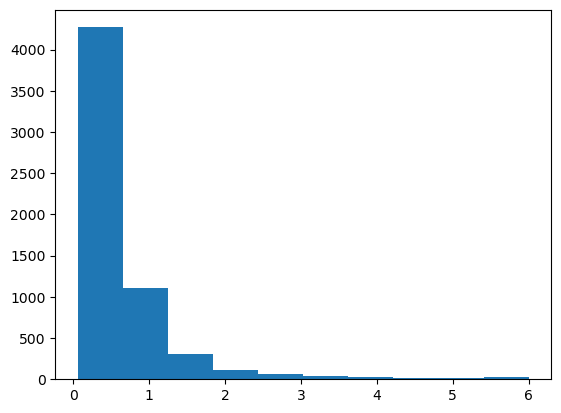

In [82]:
plt.hist(zhou_2020_data_v1['score'])

In [83]:
zhou_2020_data_v1.head()

,gene,p,score_raw,sig_flag,nonsig_flag,score
0,Glyma.04g255400,3.623048e-09,8.440926,1,0,0.389581
1,Glyma.11g239200,6.739004e-04,3.171404,1,0,0.146373
2,Glyma.03g063000,4.231147e-04,3.373542,1,0,0.155702
3,Glyma.08g285400,1.569710e-02,1.804181,1,0,0.083270
4,Glyma.10g028900,3.668476e-18,17.435514,1,0,0.804716


In [157]:
# complete whole genome
# chen2016 需要額外處理因為 p很多等於 0.00005，需要額外做 scaling
# chen_2016 = pd.read_excel(r'C:\Users\edwar\Desktop\農藝\paper2\data collection\whole genome data\complete\gene expression\Chen-2016\Chen2016_wgd.xlsx')

# leisner_2017
# leisner_2017 = pd.read_excel(r'C:\Users\edwar\Desktop\農藝\paper2\data collection\whole genome data\complete\gene expression\Leisner-2017\Leisner2017_wgd.xlsx')

# 用 log2flodchange 欄位並且取決對質後會是漂亮的 right skew，可依照這個欄位做 score re-scaling，放入資料庫中
# shi_2018 = pd.read_excel(r'C:\Users\edwar\Desktop\農藝\paper2\data collection\whole genome data\complete\gene expression\Shi-2018\whole genome data_v2.xlsx')

# 可以當 validation，有 6 12 24hr，但資料有列上下移動之風險
# shin_2015 = pd.read_excel(r'C:\Users\edwar\Desktop\農藝\paper2\data collection\whole genome data\complete\gene expression\Shin-2015\Shin2015_wgd.xlsx')

# 做額外處理，有 120 144hr，也可做驗證，已透過公式把 p轉換，當 fc < 1 先把他取倒數，之後當 p = 0 以及 p從缺時，就用公式來算出新 p
# tamang_2021 = pd.read_excel(r'C:\Users\edwar\Desktop\農藝\paper2\data collection\whole genome data\complete\gene expression\Tamang-2021\Tamang2021_wgd.xlsx')

# 這個資料庫直接放資料庫中，很讚的 right skew，且最高分不超過 7，因為處理時間只有 1種，所以不當驗證
# le_2012_v6 = pd.read_excel(r'C:\Users\edwar\Desktop\農藝\paper2\data collection\whole genome data\complete\noncoding\Le-2012\Le2012_wgd(V6).xlsx')

# 這個資料庫直接放資料庫中，很讚的 right skew，且最高分不超過 8，因為處理時間只有 1種，所以不當驗證
# le_2012_r2 = pd.read_excel(r'C:\Users\edwar\Desktop\農藝\paper2\data collection\whole genome data\complete\noncoding\Le-2012\Le2012_wgd(R2).xlsx')

chen2016

In [84]:
# chen_2016 preprocessing
chen_2016 = pd.read_excel(r'C:\Users\edwar\Desktop\農藝\paper2\data collection\whole genome data\complete\gene expression\Chen-2016\Chen2016_wgd.xlsx')
# chen_2016.loc[(chen_2016['fc'] < 1), 'fc'] = 1 / chen_2016['fc']
# chen_2016.loc[(chen_2016['p'].isna()), 'p'] = 0.1 ** np.log2(chen_2016['fc'])
# chen_2016.loc[(chen_2016['p'] == 0.00005) & (chen_2016['fc'].isna() == False), 'p'] = 0.1 ** np.log2(chen_2016['fc'])

In [85]:
chen_2016_data = chen_2016[['mapped_gene', 'p', 'fc']]
chen_2016_data_p = chen_2016_data[(chen_2016_data['fc'].isna()) | (chen_2016_data['fc'] == np.inf)].reset_index().drop(['index'], axis = 1)
chen_2016_data_pfc = chen_2016_data[(chen_2016_data['p'].isna() == False) & (chen_2016_data['fc'].isna() == False) & (chen_2016_data['fc'] != np.inf)].reset_index().drop(['index'], axis = 1)
chen_2016_data_p['score_raw'] = -np.log10(chen_2016_data_p['p'])

chen_2016_data_pfc.loc[(chen_2016_data_pfc['fc'] < 1), 'fc'] = 1 / chen_2016_data_pfc['fc']
chen_2016_data_pfc['p_raw'] = chen_2016_data_pfc['p'] ** np.log2(chen_2016_data_pfc['fc'])
chen_2016_data_pfc['score_raw'] = -np.log10(chen_2016_data_pfc['p_raw'])

In [86]:
chen_2016_data_v1 = pd.concat([chen_2016_data_p, chen_2016_data_pfc]).reset_index().drop(['index'], axis = 1)

In [87]:
chen_2016_data_v1['sig_flag'] = ''
chen_2016_data_v1['nonsig_flag'] = ''

chen_2016_data_v1.loc[(chen_2016_data_v1['p'] < 0.05), 'sig_flag'] = 1
chen_2016_data_v1.loc[(chen_2016_data_v1['p'] < 0.05), 'nonsig_flag'] = 0
chen_2016_data_v1.loc[(chen_2016_data_v1['p'] >= 0.05), 'nonsig_flag'] = 1
chen_2016_data_v1.loc[(chen_2016_data_v1['p'] >= 0.05), 'sig_flag'] = 0

In [88]:
# rescaling to [0, 5]
chen_2016_data_v1.loc[(chen_2016_data_v1['score_raw'] > 35), 'score_raw'] = 35
upper_b = 6
lower_b = 0
max_val = chen_2016_data_v1['score_raw'].max()
min_val = 0

chen_2016_data_v1['score'] = chen_2016_data_v1['score_raw'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))
chen_2016_data_v1 = chen_2016_data_v1.merge(glyma_gene_ver[['Wm82.a1.v1', 'Wm82.a2.v1']], left_on = ['mapped_gene'], right_on = ['Wm82.a1.v1'], how = 'left').drop(['Wm82.a1.v1'], axis = 1).rename(columns = {'mapped_gene':'gene_org', 'Wm82.a2.v1':'gene'})
chen_2016_data_v1 = chen_2016_data_v1[chen_2016_data_v1['gene'].isna() == False].reset_index().drop(['index'], axis = 1)

(array([2.0659e+04, 5.5450e+03, 2.3050e+03, 8.5900e+02, 3.8300e+02,
        1.8800e+02, 7.7000e+01, 4.1000e+01, 1.1000e+01, 8.0000e+00]),
 array([1.16232848e-09, 6.00000001e-01, 1.20000000e+00, 1.80000000e+00,
        2.40000000e+00, 3.00000000e+00, 3.60000000e+00, 4.20000000e+00,
        4.80000000e+00, 5.40000000e+00, 6.00000000e+00]),
 <BarContainer object of 10 artists>)

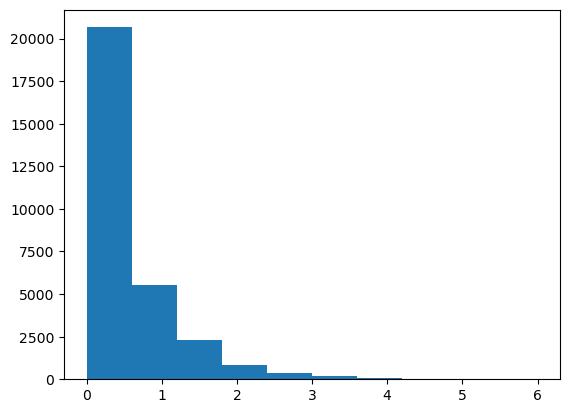

In [89]:
plt.hist(chen_2016_data_v1['score'])

In [90]:
chen_2016_data_v1.head()

,gene_org,p,fc,score_raw,p_raw,sig_flag,nonsig_flag,score,gene
0,Glyma17g14100,0.00005,inf,4.30103,NaN,1,0,0.737319,Glyma.17g131800
1,Glyma10g01630,0.00005,inf,4.30103,NaN,1,0,0.737319,Glyma.10g013200
2,Glyma20g26430,0.00005,inf,4.30103,NaN,1,0,0.737319,Glyma.20g128200
3,Glyma01g43130,0.00005,inf,4.30103,NaN,1,0,0.737319,Glyma.01g222300
4,Glyma07g31500,0.00005,inf,4.30103,NaN,1,0,0.737319,Glyma.07g195300


leisner2017

In [91]:
# leisner_2017 processing
leisner_2017 = pd.read_excel(r'C:\Users\edwar\Desktop\農藝\paper2\data collection\whole genome data\complete\gene expression\Leisner-2017\Leisner2017_wgd.xlsx')

In [92]:
leisner_2017_data = leisner_2017[['mapped_gene', 'fc']]
leisner_2017_data.loc[(leisner_2017_data['fc'] == 0), 'fc'] = 10 ** -125
leisner_2017_data.loc[(leisner_2017_data['fc'] < 1), 'fc'] = 1 / leisner_2017_data['fc']

In [93]:
leisner_2017_data['p_val'] = 0.1 ** np.log2(leisner_2017_data['fc'])
leisner_2017_data.loc[(leisner_2017_data['p_val'] == 0), 'p_val'] = 10 ** -300
leisner_2017_data['score_raw'] = -np.log10(leisner_2017_data['p_val'])

C:\Users\edwar\AppData\Local\Temp\ipykernel_10912\1373092496.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leisner_2017_data['p_val'] = 0.1 ** np.log2(leisner_2017_data['fc'])
C:\Users\edwar\AppData\Local\Temp\ipykernel_10912\1373092496.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leisner_2017_data['score_raw'] = -np.log10(leisner_2017_data['p_val'])


In [94]:
upper_b = 2   # Because of the strange distribution, we didn't set the same upper and lower bound on score range
lower_b = 0
max_val = leisner_2017_data['score_raw'].max()
min_val = 0

leisner_2017_data['score'] = leisner_2017_data['score_raw'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))
leisner_2017_data = leisner_2017_data.merge(glyma_gene_ver[['Wm82.a1.v1', 'Wm82.a2.v1']], left_on = ['mapped_gene'], right_on = ['Wm82.a1.v1'], how = 'left').drop(['Wm82.a1.v1'], axis = 1).rename(columns = {'mapped_gene':'gene_org', 'Wm82.a2.v1':'gene'})
leisner_2017_data = leisner_2017_data[leisner_2017_data['gene'].isna() == False].reset_index().drop(['index'], axis = 1)

C:\Users\edwar\AppData\Local\Temp\ipykernel_10912\1260530867.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leisner_2017_data['score'] = leisner_2017_data['score_raw'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))


In [95]:
leisner_2017_data['sig_flag'] = ''
leisner_2017_data['nonsig_flag'] = ''
leisner_2017_data.loc[(leisner_2017_data['p_val'] < 0.05), 'sig_flag'] = 1
leisner_2017_data.loc[(leisner_2017_data['p_val'] < 0.05), 'nonsig_flag'] = 0
leisner_2017_data.loc[(leisner_2017_data['p_val'] >= 0.05), 'sig_flag'] = 0
leisner_2017_data.loc[(leisner_2017_data['p_val'] >= 0.05), 'nonsig_flag'] = 1

(array([3.3531e+04, 6.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 8.7600e+02]),
 array([1.88602010e-07, 2.00000170e-01, 4.00000151e-01, 6.00000132e-01,
        8.00000113e-01, 1.00000009e+00, 1.20000008e+00, 1.40000006e+00,
        1.60000004e+00, 1.80000002e+00, 2.00000000e+00]),
 <BarContainer object of 10 artists>)

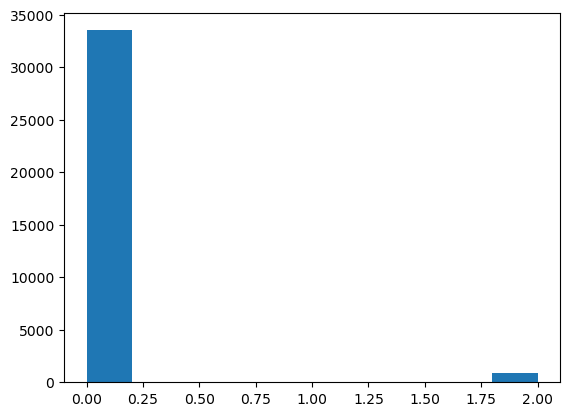

In [96]:
plt.hist(leisner_2017_data['score'])

In [97]:
leisner_2017_data.head()

,gene_org,fc,p_val,score_raw,score,gene,sig_flag,nonsig_flag
0,Glyma03g03790,1.039675,0.878755,0.056132,0.000374,Glyma.03g032000,0,1
1,Glyma14g40590,1.116020,0.694444,0.158363,0.001056,Glyma.14g217100,0,1
2,Glyma03g02470,1.023667,0.925237,0.033747,0.000225,Glyma.03g021600,0,1
3,Glyma14g17090,1.275563,0.445518,0.351135,0.002341,Glyma.14g132800,0,1
4,Glyma10g44500,1.171063,0.591808,0.227819,0.001519,Glyma.10g297600,0,1


shi2018

In [98]:
shi_2018 = pd.read_excel(r'C:\Users\edwar\Desktop\農藝\paper2\data collection\whole genome data\complete\gene expression\Shi-2018\whole genome data_v2.xlsx')

In [99]:
shi_2018_data = shi_2018[['gene', 'log2FoldChange(GH_treat/CK_treat)']]
shi_2018_data['log2FoldChange(GH_treat/CK_treat)'] = abs(shi_2018_data['log2FoldChange(GH_treat/CK_treat)'])

C:\Users\edwar\AppData\Local\Temp\ipykernel_10912\3544701215.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shi_2018_data['log2FoldChange(GH_treat/CK_treat)'] = abs(shi_2018_data['log2FoldChange(GH_treat/CK_treat)'])


In [100]:
shi_2018_data = shi_2018_data[shi_2018_data['gene'].str.contains('Glyma') == True]
shi_2018_data['p_val'] = 0.1 ** shi_2018_data['log2FoldChange(GH_treat/CK_treat)']
gene_list = list(shi_2018_data['gene'].unique())
shi_2018_data_v1 = pd.DataFrame()

count = 0
for gene in gene_list:
    df_gene = shi_2018_data[shi_2018_data['gene'] == gene].reset_index().drop(['index'], axis = 1)
    if len(df_gene['gene']) > 1:
        df_gene_v1 = pd.DataFrame()
        p_values = list(df_gene['p_val'])
        p_value = stats.combine_pvalues(p_values, method = 'fisher')[1]
        df_gene_v1['gene'] = df_gene['gene'].unique()
        df_gene_v1['p'] = p_value
        df_gene_v1['score_raw'] = -np.log10(df_gene_v1['p'])
        shi_2018_data_v1 = pd.concat([shi_2018_data_v1, df_gene_v1]).reset_index().drop(['index'], axis = 1)
        
    elif len(df_gene['gene']) == 1:
        df_gene['score_raw'] = -np.log10(df_gene.rename(columns = {'p_val':'p'})['p'])
        shi_2018_data_v1 = pd.concat([shi_2018_data_v1, df_gene]).reset_index().drop(['index'], axis = 1)
        
    count += 1
    if count % 6000 == 0:
        print(count)

6000
12000
18000
24000
30000
36000


In [101]:
shi_2018_data_v1['sig_flag'] = ''
shi_2018_data_v1['nonsig_flag'] = ''
shi_2018_data_v1.loc[(shi_2018_data_v1['p_val'] < 0.05), 'sig_flag'] = 1
shi_2018_data_v1.loc[(shi_2018_data_v1['p'] < 0.05), 'sig_flag'] = 1
shi_2018_data_v1.loc[(shi_2018_data_v1['p_val'] < 0.05), 'nonsig_flag'] = 0
shi_2018_data_v1.loc[(shi_2018_data_v1['p'] < 0.05), 'nonsig_flag'] = 0
shi_2018_data_v1.loc[(shi_2018_data_v1['p_val'] >= 0.05), 'nonsig_flag'] = 1
shi_2018_data_v1.loc[(shi_2018_data_v1['p'] >= 0.05), 'nonsig_flag'] = 1
shi_2018_data_v1.loc[(shi_2018_data_v1['p_val'] >= 0.05), 'sig_flag'] = 0
shi_2018_data_v1.loc[(shi_2018_data_v1['p'] >= 0.05), 'sig_flag'] = 0

(array([2.4298e+04, 8.7330e+03, 3.0350e+03, 1.1340e+03, 2.1200e+02,
        5.1000e+01, 1.0000e+01, 4.0000e+00, 4.0000e+00, 4.0000e+00]),
 array([4.46000000e-05, 2.08643922e+00, 4.17283384e+00, 6.25922846e+00,
        8.34562308e+00, 1.04320177e+01, 1.25184123e+01, 1.46048069e+01,
        1.66912016e+01, 1.87775962e+01, 2.08639908e+01]),
 <BarContainer object of 10 artists>)

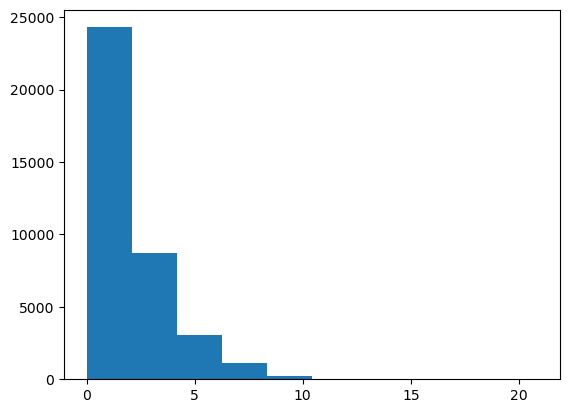

In [102]:
plt.hist(shi_2018_data_v1['score_raw'])

In [103]:
shi_2018_data_v1.loc[(shi_2018_data_v1['score_raw'] > 13), 'score_raw'] = 13
upper_b = 6
lower_b = 0
max_val = shi_2018_data_v1['score_raw'].max()
min_val = 0

shi_2018_data_v1['score'] = shi_2018_data_v1['score_raw'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

(array([17218., 10160.,  4982.,  2556.,  1338.,   735.,   331.,    91.,
           43.,    31.]),
 array([2.05846154e-05, 6.00018526e-01, 1.20001647e+00, 1.80001441e+00,
        2.40001235e+00, 3.00001029e+00, 3.60000823e+00, 4.20000618e+00,
        4.80000412e+00, 5.40000206e+00, 6.00000000e+00]),
 <BarContainer object of 10 artists>)

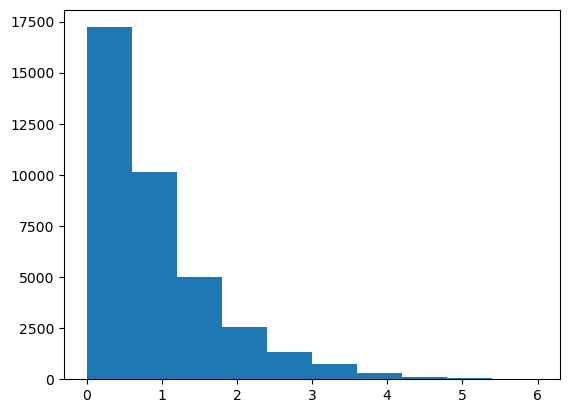

In [104]:
plt.hist(shi_2018_data_v1['score'])

In [105]:
shi_2018_data_v1.head()

,gene,log2FoldChange(GH_treat/CK_treat),p_val,score_raw,p,sig_flag,nonsig_flag,score
0,Glyma.09g185500,15.039778,9.124763e-16,13.000000,NaN,1,0,6.000000
1,Glyma.08g156600,13.093538,8.062353e-14,13.000000,NaN,1,0,6.000000
2,Glyma.18g129800,12.609025,2.460224e-13,12.609025,NaN,1,0,5.819550
3,Glyma.10g064400,12.249392,5.631289e-13,12.249392,NaN,1,0,5.653566
4,Glyma.16g021000,11.983334,1.039120e-12,11.983334,NaN,1,0,5.530770


tamang2021  validation 120hr, 144hr

In [106]:
# tamang_2021 preprocessing v1
tamang_2021 = pd.read_excel(r'C:\Users\edwar\Desktop\農藝\paper2\data collection\whole genome data\complete\gene expression\Tamang-2021\Tamang2021_wgd.xlsx')

tamang_2021_data_120 = tamang_2021[tamang_2021['drought_treatment_span'] == 120][['mapped_gene', 'p', 'fc']].reset_index().drop(['index'], axis = 1)
tamang_2021_data_120.loc[(tamang_2021_data_120['fc'] < 1), 'fc'] = 1 / tamang_2021_data_120['fc']
tamang_2021_data_120['p_val'] = 0.1 ** np.log2(tamang_2021_data_120['fc'])
tamang_2021_data_120['sig_flag'] = ''
tamang_2021_data_120['nonsig_flag'] = ''
tamang_2021_data_120.loc[(tamang_2021_data_120['p'] < 0.05), 'sig_flag'] = 1
tamang_2021_data_120.loc[(tamang_2021_data_120['p'] < 0.05), 'nonsig_flag'] = 0
tamang_2021_data_120.loc[(tamang_2021_data_120['p'] >= 0.05), 'sig_flag'] = 0
tamang_2021_data_120.loc[(tamang_2021_data_120['p'] >= 0.05), 'nonsig_flag'] = 1
tamang_2021_data_120.loc[((tamang_2021_data_120['p'].isna()) & (tamang_2021_data_120['fc'] > 1.5)), 'sig_flag'] = 1
tamang_2021_data_120.loc[((tamang_2021_data_120['p'].isna()) & (tamang_2021_data_120['fc'] > 1.5)), 'nonsig_flag'] = 0
tamang_2021_data_120.loc[((tamang_2021_data_120['p'].isna()) & (tamang_2021_data_120['fc'] <= 1.5)), 'sig_flag'] = 0
tamang_2021_data_120.loc[((tamang_2021_data_120['p'].isna()) & (tamang_2021_data_120['fc'] <= 1.5)), 'nonsig_flag'] = 1


tamang_2021_data_144 = tamang_2021[tamang_2021['drought_treatment_span'] == 144][['mapped_gene', 'p', 'fc']].reset_index().drop(['index'], axis = 1)
tamang_2021_data_144.loc[(tamang_2021_data_144['fc'] < 1), 'fc'] = 1 / tamang_2021_data_144['fc']
tamang_2021_data_144['p_val'] = 0.1 ** np.log2(tamang_2021_data_144['fc'])
tamang_2021_data_144['sig_flag'] = ''
tamang_2021_data_144['nonsig_flag'] = ''
tamang_2021_data_144.loc[(tamang_2021_data_144['p'] < 0.05), 'sig_flag'] = 1
tamang_2021_data_144.loc[(tamang_2021_data_144['p'] < 0.05), 'nonsig_flag'] = 0
tamang_2021_data_144.loc[(tamang_2021_data_144['p'] >= 0.05), 'sig_flag'] = 0
tamang_2021_data_144.loc[(tamang_2021_data_144['p'] >= 0.05), 'nonsig_flag'] = 1
tamang_2021_data_144.loc[((tamang_2021_data_144['p'].isna()) & (tamang_2021_data_144['fc'] > 1.5)), 'sig_flag'] = 1
tamang_2021_data_144.loc[((tamang_2021_data_144['p'].isna()) & (tamang_2021_data_144['fc'] > 1.5)), 'nonsig_flag'] = 0
tamang_2021_data_144.loc[((tamang_2021_data_144['p'].isna()) & (tamang_2021_data_144['fc'] <= 1.5)), 'sig_flag'] = 0
tamang_2021_data_144.loc[((tamang_2021_data_144['p'].isna()) & (tamang_2021_data_144['fc'] <= 1.5)), 'nonsig_flag'] = 1


tamang_2021_data = pd.concat([tamang_2021_data_120, tamang_2021_data_144]).reset_index().drop(['index'], axis = 1)

gene_list = list(tamang_2021_data['mapped_gene'].unique())
tamang_2021_data_v1 = pd.DataFrame()
count = 0
for gene in gene_list:
    df_gene = tamang_2021_data[tamang_2021_data['mapped_gene'] == gene].reset_index().drop(['index'], axis = 1)
    df_gene_v1 = pd.DataFrame()
    p_values = list(df_gene['p_val'])
    p_value = stats.combine_pvalues(p_values, method = 'fisher')[1]
    df_gene_v1['gene'] = df_gene['mapped_gene'].unique()
    df_gene_v1['p'] = p_value
    df_gene_v1['score_raw'] = -np.log10(df_gene_v1['p'])
    df_gene_v1['sig_flag'] = df_gene['sig_flag'].sum()
    df_gene_v1['nonsig_flag'] = df_gene['nonsig_flag'].sum()
    tamang_2021_data_v1 = pd.concat([tamang_2021_data_v1, df_gene_v1]).reset_index().drop(['index'], axis = 1)
    count += 1
    if count % 5000 == 0:
        print(count)

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000


In [107]:
tamang_2021_data_v1['score_raw_v1'] = tamang_2021_data_v1['score_raw']
tamang_2021_data_v1.loc[(tamang_2021_data_v1['score_raw_v1'] > 18), 'score_raw_v1'] = 18

upper_b = 6
lower_b = 0
max_val = tamang_2021_data_v1['score_raw_v1'].max()
min_val = 0

tamang_2021_data_v1['score'] = tamang_2021_data_v1['score_raw_v1'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

(array([4.0313e+04, 7.0840e+03, 2.4780e+03, 1.0110e+03, 4.5100e+02,
        2.3500e+02, 1.3100e+02, 7.0000e+01, 4.0000e+01, 5.0000e+01]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

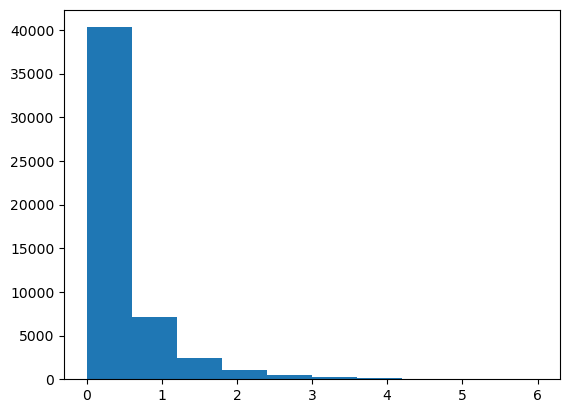

In [108]:
plt.hist(tamang_2021_data_v1['score'])

In [109]:
tamang_2021_data_v1.head()

,gene,p,score_raw,sig_flag,nonsig_flag,score_raw_v1,score
0,Glyma.01g000100,0.837028,0.077260,0,2,0.077260,0.025753
1,Glyma.01g000200,0.777675,0.109202,0,2,0.109202,0.036401
2,Glyma.01g000300,1.000000,-0.000000,0,2,-0.000000,0.000000
3,Glyma.01g000400,0.713474,0.146622,1,1,0.146622,0.048874
4,Glyma.01g000500,0.785231,0.105003,0,2,0.105003,0.035001


In [103]:
# tamang_2021 preprocessing v2
# tamang_2021 = pd.read_excel(r'C:\Users\edwar\Desktop\農藝\paper2\data collection\whole genome data\complete\gene expression\Tamang-2021\Tamang2021_wgd.xlsx')

# tamang_2021_data_120 = tamang_2021[tamang_2021['drought_treatment_span'] == 120][['mapped_gene', 'p', 'fc']]
# tamang_2021_data_120.loc[(tamang_2021_data_120['fc'] < 1), 'fc'] = 1 / tamang_2021_data_120['fc']
# tamang_2021_data_120['p_val'] = 0.1 ** np.log2(tamang_2021_data_120['fc'])
# tamang_2021_data_120['score_raw'] = -np.log10(tamang_2021_data_120['p_val'])
# tamang_2021_data_120.loc[(tamang_2021_data_120['score_raw'] > 9.6), 'score_raw'] = 9.6

# upper_b = 6
# lower_b = 0
# max_val = tamang_2021_data_120['score_raw'].max()
# min_val = 0
# tamang_2021_data_120['score'] = tamang_2021_data_120['score_raw'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

# tamang_2021_data_144 = tamang_2021[tamang_2021['drought_treatment_span'] == 144][['mapped_gene', 'p', 'fc']]
# tamang_2021_data_144.loc[(tamang_2021_data_144['fc'] < 1), 'fc'] = 1 / tamang_2021_data_144['fc']
# tamang_2021_data_144['p_val'] = 0.1 ** np.log2(tamang_2021_data_144['fc'])
# tamang_2021_data_144['score_raw'] = -np.log10(tamang_2021_data_144['p_val'])
# tamang_2021_data_144.loc[(tamang_2021_data_144['score_raw'] > 10.2), 'score_raw'] = 10.2

# upper_b = 6
# lower_b = 0
# max_val = tamang_2021_data_144['score_raw'].max()
# min_val = 0
# tamang_2021_data_144['score'] = tamang_2021_data_144['score_raw'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

le2012

In [110]:
le_2012_v6 = pd.read_excel(r'C:\Users\edwar\Desktop\農藝\paper2\data collection\whole genome data\complete\noncoding\Le-2012\Le2012_wgd(V6).xlsx')
le_2012_r2 = pd.read_excel(r'C:\Users\edwar\Desktop\農藝\paper2\data collection\whole genome data\complete\noncoding\Le-2012\Le2012_wgd(R2).xlsx')

In [111]:
le_2012_v6_data = le_2012_v6[['mapped_gene', 'p', 'fc']]
le_2012_r2_data = le_2012_r2[['mapped_gene', 'p', 'fc']]

In [112]:
le_2012_v6_data.loc[(le_2012_v6_data['fc'] < 1), 'fc'] = 1 / le_2012_v6_data['fc']
le_2012_v6_data['p_val'] = le_2012_v6_data['p'] ** np.log2(le_2012_v6_data['fc'])
le_2012_r2_data.loc[(le_2012_r2_data['fc'] < 1), 'fc'] = 1 / le_2012_r2_data['fc']
le_2012_r2_data['p_val'] = le_2012_r2_data['p'] ** np.log2(le_2012_r2_data['fc'])

le_2012_v6_data['sig_flag'] = ''
le_2012_v6_data['nonsig_flag'] = ''
le_2012_v6_data.loc[(le_2012_v6_data['p'] < 0.05), 'sig_flag'] = 1
le_2012_v6_data.loc[(le_2012_v6_data['p'] < 0.05), 'nonsig_flag'] = 0
le_2012_v6_data.loc[(le_2012_v6_data['p'] >= 0.05), 'nonsig_flag'] = 1
le_2012_v6_data.loc[(le_2012_v6_data['p'] >= 0.05), 'sig_flag'] = 0

le_2012_r2_data['sig_flag'] = ''
le_2012_r2_data['nonsig_flag'] = ''
le_2012_r2_data.loc[(le_2012_r2_data['p'] < 0.05), 'sig_flag'] = 1
le_2012_r2_data.loc[(le_2012_r2_data['p'] < 0.05), 'nonsig_flag'] = 0
le_2012_r2_data.loc[(le_2012_r2_data['p'] >= 0.05), 'nonsig_flag'] = 1
le_2012_r2_data.loc[(le_2012_r2_data['p'] >= 0.05), 'sig_flag'] = 0

le_2012_data = pd.concat([le_2012_v6_data, le_2012_r2_data]).reset_index().drop(['index'], axis = 1)

C:\Users\edwar\AppData\Local\Temp\ipykernel_10912\1559478123.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  le_2012_v6_data['p_val'] = le_2012_v6_data['p'] ** np.log2(le_2012_v6_data['fc'])
C:\Users\edwar\AppData\Local\Temp\ipykernel_10912\1559478123.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  le_2012_r2_data['p_val'] = le_2012_r2_data['p'] ** np.log2(le_2012_r2_data['fc'])
C:\Users\edwar\AppData\Local\Temp\ipykernel_10912\1559478123.py:6: SettingWithCopyWarning: 
A value is trying to be set on

In [113]:
gene_list = list(le_2012_data['mapped_gene'].unique())
le_2012_data_v1 = pd.DataFrame()

count = 0
for gene in gene_list:
    df_gene = le_2012_data[le_2012_data['mapped_gene'] == gene].reset_index().drop(['index'], axis = 1)
    df_gene_v1 = pd.DataFrame()
    p_values = list(df_gene['p_val'])
    p_value = stats.combine_pvalues(p_values, method = 'fisher')[1]
    df_gene_v1['gene'] = df_gene['mapped_gene'].unique()
    df_gene_v1['p'] = p_value
    df_gene_v1['sig_flag'] = df_gene['sig_flag'].sum()
    df_gene_v1['nonsig_flag'] = df_gene['nonsig_flag'].sum()
    df_gene_v1['score_raw'] = -np.log10(df_gene_v1['p'])
    le_2012_data_v1 = pd.concat([le_2012_data_v1, df_gene_v1]).reset_index().drop(['index'], axis = 1)
    
    count += 1
    if count % 4000 == 0:
        print(count)

4000
8000
12000
16000
20000
24000
28000
32000
36000
40000


In [114]:
le_2012_data_v1['score_raw_v1'] = le_2012_data_v1['score_raw']
le_2012_data_v1.loc[(le_2012_data_v1['score_raw_v1'] > 30), 'score_raw_v1'] = 30

In [115]:
upper_b = 6
lower_b = 0
max_val = le_2012_data_v1['score_raw_v1'].max()
min_val = 0

le_2012_data_v1['score'] = le_2012_data_v1['score_raw_v1'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))
le_2012_data_v1 = le_2012_data_v1.merge(glyma_gene_ver[['Wm82.a1.v1', 'Wm82.a2.v1']], left_on = ['gene'], right_on = ['Wm82.a1.v1']).drop(['Wm82.a1.v1'], axis = 1).rename(columns = {'gene':'gene_org', 'Wm82.a2.v1':'gene'})
le_2012_data_v1 = le_2012_data_v1[le_2012_data_v1['gene'].isna() == False].reset_index().drop(['index'], axis = 1)

In [116]:
le_2012_data_v1.head()

,gene_org,p,sig_flag,nonsig_flag,score_raw,score_raw_v1,score,gene
0,Glyma01g00300,0.068744,1,1,1.162766,1.162766,0.232553,Glyma.01g000400
1,Glyma01g00320,0.768163,0,2,0.114546,0.114546,0.022909,Glyma.01g000600
2,Glyma01g00380,0.650312,0,2,0.186878,0.186878,0.037376,Glyma.01g000900
3,Glyma01g00400,0.603801,1,1,0.219106,0.219106,0.043821,Glyma.01g001000
4,Glyma01g00410,0.000009,1,1,5.060139,5.060139,1.012028,Glyma.01g001100


(array([3.4386e+04, 2.2850e+03, 7.9200e+02, 3.1900e+02, 1.8100e+02,
        9.4000e+01, 6.1000e+01, 3.1000e+01, 1.0000e+01, 3.1000e+01]),
 array([3.1958333e-11, 6.0000000e-01, 1.2000000e+00, 1.8000000e+00,
        2.4000000e+00, 3.0000000e+00, 3.6000000e+00, 4.2000000e+00,
        4.8000000e+00, 5.4000000e+00, 6.0000000e+00]),
 <BarContainer object of 10 artists>)

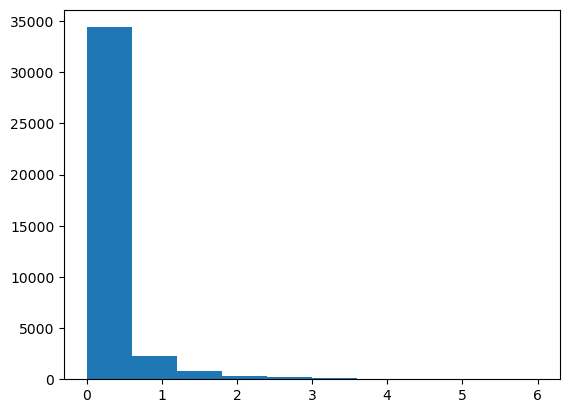

In [117]:
plt.hist(le_2012_data_v1['score'])

shin2015 validation 1 12 24hr

In [118]:
shin_2015 = pd.read_excel(r'C:\Users\edwar\Desktop\農藝\paper2\data collection\whole genome data\complete\gene expression\Shin-2015\Shin2015_wgd.xlsx')

In [119]:
shin_2015_data = shin_2015[['mapped_gene', 'p', 'fc', 'drought_treatment_span']]
shin_2015_data_6h = shin_2015_data[shin_2015_data['drought_treatment_span'] == 6].reset_index().drop(['index'], axis = 1)
shin_2015_data_12h = shin_2015_data[shin_2015_data['drought_treatment_span'] == 12].reset_index().drop(['index'], axis = 1)
shin_2015_data_24h = shin_2015_data[shin_2015_data['drought_treatment_span'] == 24].reset_index().drop(['index'], axis = 1)\

shin_2015_data_6h.loc[(shin_2015_data_6h['fc'] < 1), 'fc'] = 1 / shin_2015_data_6h['fc']
shin_2015_data_12h.loc[(shin_2015_data_12h['fc'] < 1), 'fc'] = 1 / shin_2015_data_12h['fc']
shin_2015_data_24h.loc[(shin_2015_data_24h['fc'] < 1), 'fc'] = 1 / shin_2015_data_24h['fc']

shin_2015_data_6h['p_val'] = 0.1 ** np.log2(shin_2015_data_6h['fc'])
shin_2015_data_12h['p_val'] = 0.1 ** np.log2(shin_2015_data_12h['fc'])
shin_2015_data_24h['p_val'] = 0.1 ** np.log2(shin_2015_data_24h['fc'])

shin_2015_data = pd.concat([shin_2015_data_6h, shin_2015_data_12h, shin_2015_data_24h]).reset_index().drop(['index'], axis = 1)

shin_2015_data['sig_flag'] = ''
shin_2015_data['nonsig_flag'] = ''
shin_2015_data.loc[(shin_2015_data['fc'] > 1.5), 'sig_flag'] = 1
shin_2015_data.loc[(shin_2015_data['fc'] > 1.5), 'nonsig_flag'] = 0
shin_2015_data.loc[(shin_2015_data['fc'] <= 1.5), 'sig_flag'] = 0
shin_2015_data.loc[(shin_2015_data['fc'] <= 1.5), 'nonsig_flag'] = 1

shin_2015_data_v1 = shin_2015_data.merge(glyma_gene_ver[['Wm82.a1.v1', 'Wm82.a2.v1']], how = 'left', left_on = ['mapped_gene'], right_on = ['Wm82.a1.v1']).drop(['Wm82.a1.v1'], axis = 1).rename(columns = {'Wm82.a2.v1':'gene', 'mapped_gene':'gene_org'})
shin_2015_data_v1 = shin_2015_data_v1[shin_2015_data_v1['gene'].isna() == False].reset_index().drop(['index'], axis = 1)



In [120]:
gene_list = list(shin_2015_data_v1['gene'].unique())
shin_2015_data_v2 = pd.DataFrame()

count = 0
for gene in  gene_list:
    df_gene = shin_2015_data_v1[shin_2015_data_v1['gene'] == gene].reset_index().drop(['index'], axis = 1)
    df_gene_v1 = pd.DataFrame()
    p_values = list(df_gene['p_val'])
    p_value = stats.combine_pvalues(p_values, method = 'fisher')[1]
    df_gene_v1['gene'] = df_gene['gene'].unique()
    df_gene_v1['p'] = p_value
    df_gene_v1['score_raw'] = -np.log10(df_gene_v1['p'])
    df_gene_v1['sig_flag'] = df_gene['sig_flag'].sum()
    df_gene_v1['nonsig_flag'] = df_gene['nonsig_flag'].sum()
    shin_2015_data_v2 = pd.concat([shin_2015_data_v2, df_gene_v1]).reset_index().drop(['index'], axis = 1)
    
    count += 1
    if count % 5000 == 0:
        print(count)

5000
10000
15000
20000
25000


In [121]:
shin_2015_data_v2['score_raw_v1'] = shin_2015_data_v2['score_raw']
shin_2015_data_v2.loc[(shin_2015_data_v2['score_raw_v1'] > 17.4), 'score_raw_v1'] = 17.4

upper_b = 6
lower_b = 0
max_val = shin_2015_data_v2['score_raw_v1'].max()
min_val = 0
shin_2015_data_v2['score'] = shin_2015_data_v2['score_raw_v1'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

(array([19298.,  4037.,  1552.,   987.,   734.,   430.,   245.,   415.,
           33.,    37.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

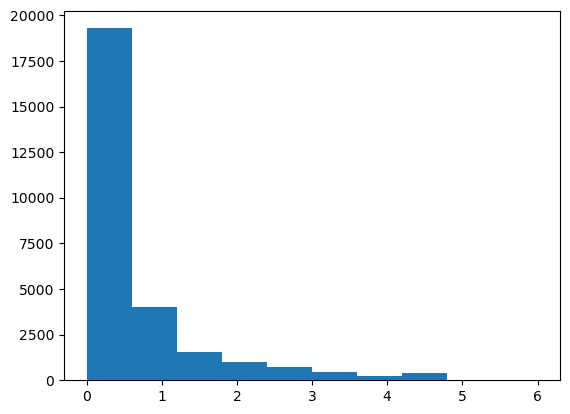

In [122]:
plt.hist(shin_2015_data_v2['score'])

In [123]:
shin_2015_data_v2.head()

,gene,p,score_raw,sig_flag,nonsig_flag,score_raw_v1,score
0,Glyma.03g032000,0.169787,0.770095,1,2,0.770095,0.265550
1,Glyma.14g217100,0.443675,0.352935,1,2,0.352935,0.121702
2,Glyma.03g021600,0.286500,0.542876,1,2,0.542876,0.187199
3,Glyma.14g132800,1.000000,-0.000000,0,3,-0.000000,0.000000
4,Glyma.15g226000,1.000000,-0.000000,0,3,-0.000000,0.000000


integration

gene_score_data_v1: individual study

incomplete: kim_2020_data_v1, rodrigues_2015_data, tripathi_2016_data_v1, wang_2021_data, xuan_2022_data, zhou_2020_data_v1

complete: chen_2016_data_v1, leisner_2017_data, shi_2018_data_v1, le_2012_data_v1, tamang_2021_data_v1(val), shin_2015_data_v2(val)

In [124]:
gene_score_data_v1 = gene_score_data_v1.rename(columns = {'score':'score_individual'})
kim_2020_data_v1 = kim_2020_data_v1.rename(columns = {'score':'score_kim2020'})
rodrigues_2015_data = rodrigues_2015_data.rename(columns = {'score':'score_rodrigues2015'})
tripathi_2016_data_v1 = tripathi_2016_data_v1.rename(columns = {'score':'score_tripathi2016'})
wang_2021_data = wang_2021_data.rename(columns = {'mapped_gene':'gene', 'score':'score_wang2021'})
xuan_2022_data = xuan_2022_data.rename(columns = {'mapped_gene':'gene', 'score':'score_xuan2022'})
zhou_2020_data_v1 = zhou_2020_data_v1.rename(columns = {'score':'score_zhou2020'})
chen_2016_data_v1 = chen_2016_data_v1.rename(columns = {'score':'score_chen2016'})
leisner_2017_data = leisner_2017_data.rename(columns = {'score':'score_leisner2017'})
shi_2018_data_v1 = shi_2018_data_v1.rename(columns = {'score':'score_shi2018'})
le_2012_data_v1 = le_2012_data_v1.rename(columns = {'score':'score_le2012'})
tamang_2021_data_v1 = tamang_2021_data_v1.rename(columns = {'score':'score_tamang2021'})
shin_2015_data_v2 = shin_2015_data_v2.rename(columns = {'score':'score_shin2015'})

In [125]:
gene_score_data_v1 = gene_score_data_v1.rename(columns = {'sig_flag':'sig_flag_individual', 'nonsig_flag':'nonsig_flag_individual'})
kim_2020_data_v1 = kim_2020_data_v1.rename(columns = {'sig_flag':'sig_flag_kim2020', 'nonsig_flag':'nonsig_flag_kim2020'})
rodrigues_2015_data = rodrigues_2015_data.rename(columns = {'sig_flag':'sig_flag_rodrigues2015', 'nonsig_flag':'nonsig_flag_rodrigues2015'})
tripathi_2016_data_v1 = tripathi_2016_data_v1.rename(columns = {'sig_flag':'sig_flag_tripathi2016', 'nonsig_flag':'nonsig_flag_tripathi2016'})
wang_2021_data = wang_2021_data.rename(columns = {'sig_flag':'sig_flag_wang2021', 'nonsig_flag':'nonsig_flag_wang2021'})
xuan_2022_data = xuan_2022_data.rename(columns = {'sig_flag':'sig_flag_xuan2022', 'nonsig_flag':'nonsig_flag_xuan2022'})
zhou_2020_data_v1 = zhou_2020_data_v1.rename(columns = {'sig_flag':'sig_flag_zhou2020', 'nonsig_flag':'nonsig_flag_zhou2020'})
chen_2016_data_v1 = chen_2016_data_v1.rename(columns = {'sig_flag':'sig_flag_chen2016', 'nonsig_flag':'nonsig_flag_chen2016'})
leisner_2017_data = leisner_2017_data.rename(columns = {'sig_flag':'sig_flag_leisner2017', 'nonsig_flag':'nonsig_flag_leisner2017'})
shi_2018_data_v1 = shi_2018_data_v1.rename(columns = {'sig_flag':'sig_flag_shi2018', 'nonsig_flag':'nonsig_flag_shi2018'})
le_2012_data_v1 = le_2012_data_v1.rename(columns = {'sig_flag':'sig_flag_le2012', 'nonsig_flag':'nonsig_flag_le2012'})
tamang_2021_data_v1 = tamang_2021_data_v1.rename(columns = {'sig_flag':'sig_flag_tamang2021', 'nonsig_flag':'nonsig_flag_tamang2021'})
shin_2015_data_v2 = shin_2015_data_v2.rename(columns = {'sig_flag':'sig_flag_shin2015', 'nonsig_flag':'nonsig_flag_shin2015'})

In [126]:
# including RNA Layer validation set
gene_score_total = gene_score_data_v1[['gene', 'score_individual', 'sig_flag_individual', 'nonsig_flag_individual']].merge(kim_2020_data_v1[['gene', 'score_kim2020', 'sig_flag_kim2020', 'nonsig_flag_kim2020']], on = ['gene'], how = 'outer').merge(rodrigues_2015_data[['gene', 'score_rodrigues2015', 'sig_flag_rodrigues2015', 'nonsig_flag_rodrigues2015']], on = ['gene'], how = 'outer').merge(tripathi_2016_data_v1[['gene', 'score_tripathi2016', 'sig_flag_tripathi2016', 'nonsig_flag_tripathi2016']], on = ['gene'], how = 'outer').merge(wang_2021_data[['gene', 'score_wang2021', 'sig_flag_wang2021', 'nonsig_flag_wang2021']], on = ['gene'], how = 'outer').merge(zhou_2020_data_v1[['gene', 'score_zhou2020', 'sig_flag_zhou2020', 'nonsig_flag_zhou2020']], on = ['gene'], how = 'outer').merge(chen_2016_data_v1[['gene', 'score_chen2016', 'sig_flag_chen2016', 'nonsig_flag_chen2016']], on = ['gene'], how = 'outer').merge(leisner_2017_data[['gene', 'score_leisner2017', 'sig_flag_leisner2017', 'nonsig_flag_leisner2017']], on = ['gene'], how = 'outer').merge(shi_2018_data_v1[['gene', 'score_shi2018', 'sig_flag_shi2018', 'nonsig_flag_shi2018']], on = ['gene'], how = 'outer').merge(le_2012_data_v1[['gene', 'score_le2012', 'sig_flag_le2012', 'nonsig_flag_le2012']], on = ['gene'], how = 'outer').merge(tamang_2021_data_v1[['gene', 'score_tamang2021', 'sig_flag_tamang2021', 'nonsig_flag_tamang2021']], on = ['gene'], how = 'outer').merge(shin_2015_data_v2[['gene', 'score_shin2015', 'sig_flag_shin2015', 'nonsig_flag_shin2015']], on = ['gene'], how = 'outer')
gene_score_total = gene_score_total[gene_score_total['gene'].str.contains('Glyma')].reset_index().drop(['index'], axis = 1)

In [127]:
gene_score_total['score_total'] = gene_score_total[['score_individual', 'score_kim2020', 'score_rodrigues2015', 'score_tripathi2016', 'score_wang2021', 'score_zhou2020', 'score_chen2016', 'score_leisner2017', 'score_shi2018', 'score_le2012', 'score_tamang2021', 'score_shin2015']].sum(axis = 1)
gene_score_total['sigflag_total'] = gene_score_total[['sig_flag_individual', 'sig_flag_kim2020', 'sig_flag_rodrigues2015', 'sig_flag_tripathi2016', 'sig_flag_wang2021', 'sig_flag_zhou2020', 'sig_flag_chen2016', 'sig_flag_leisner2017', 'sig_flag_shi2018', 'sig_flag_le2012', 'sig_flag_tamang2021', 'sig_flag_shin2015']].sum(axis = 1)
gene_score_total['nonsigflag_total'] = gene_score_total[['nonsig_flag_individual', 'nonsig_flag_kim2020', 'nonsig_flag_rodrigues2015', 'nonsig_flag_tripathi2016', 'nonsig_flag_wang2021', 'nonsig_flag_zhou2020', 'nonsig_flag_chen2016', 'nonsig_flag_leisner2017', 'nonsig_flag_shi2018', 'nonsig_flag_le2012', 'nonsig_flag_tamang2021', 'nonsig_flag_shin2015']].sum(axis = 1)

C:\Users\edwar\AppData\Local\Temp\ipykernel_10912\1016031580.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  gene_score_total['sigflag_total'] = gene_score_total[['sig_flag_individual', 'sig_flag_kim2020', 'sig_flag_rodrigues2015', 'sig_flag_tripathi2016', 'sig_flag_wang2021', 'sig_flag_zhou2020', 'sig_flag_chen2016', 'sig_flag_leisner2017', 'sig_flag_shi2018', 'sig_flag_le2012', 'sig_flag_tamang2021', 'sig_flag_shin2015']].sum(axis = 1)
C:\Users\edwar\AppData\Local\Temp\ipykernel_10912\1016031580.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  gene_score_total['nonsigflag_total'] = gene_score_total[['nonsig_flag_individual', 'nonsig_flag_kim20

In [128]:
gene_score_total.head()

,gene,score_individual,sig_flag_individual,nonsig_flag_individual,score_kim2020,sig_flag_kim2020,nonsig_flag_kim2020,score_rodrigues2015,sig_flag_rodrigues2015,nonsig_flag_rodrigues2015,score_tripathi2016,sig_flag_tripathi2016,nonsig_flag_tripathi2016,score_wang2021,sig_flag_wang2021,nonsig_flag_wang2021,score_zhou2020,sig_flag_zhou2020,nonsig_flag_zhou2020,score_chen2016,sig_flag_chen2016,nonsig_flag_chen2016,score_leisner2017,sig_flag_leisner2017,nonsig_flag_leisner2017,score_shi2018,sig_flag_shi2018,nonsig_flag_shi2018,score_le2012,sig_flag_le2012,nonsig_flag_le2012,score_tamang2021,sig_flag_tamang2021,nonsig_flag_tamang2021,score_shin2015,sig_flag_shin2015,nonsig_flag_shin2015,score_total,sigflag_total,nonsigflag_total
0,Glyma.05g039900,0.161962,2,0,NaN,NaN,NaN,NaN,NaN,NaN,0.127345,1,0,1.055032,1,0,0.807834,1,0,0.391703,1,0,0.001801,0,1,2.175267,1,0,0.762800,2.0,0.0,0.605213,2,0,NaN,NaN,NaN,6.088957,2.0,0.0
1,Glyma.11g131900,0.115903,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002940,0,1,NaN,NaN,NaN,0.000954,0.0,2.0,0.438231,2,0,NaN,NaN,NaN,0.558028,0.0,2.0
2,Glyma.13g322100,0.110120,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.096000,1,0,NaN,NaN,NaN,0.684193,1,0,NaN,NaN,NaN,2.000000,1,0,0.444204,0,1,0.005801,0.0,2.0,1.108281,2,0,NaN,NaN,NaN,4.448599,0.0,2.0
3,Glyma.05g123700,0.111244,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.026026,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000599,0.0,2.0,0.686042,0,2,NaN,NaN,NaN,2.823912,0.0,2.0
4,Glyma.09g163300,0.119740,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.498962,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006599,0.0,2.0,0.132019,0,2,NaN,NaN,NaN,0.757320,0.0,2.0


(array([4.6959e+04, 7.2150e+03, 1.8730e+03, 6.4400e+02, 2.3100e+02,
        7.9000e+01, 4.4000e+01, 2.5000e+01, 1.4000e+01, 8.0000e+00]),
 array([ 0.        ,  4.08027624,  8.16055249, 12.24082873, 16.32110498,
        20.40138122, 24.48165747, 28.56193371, 32.64220996, 36.7224862 ,
        40.80276245]),
 <BarContainer object of 10 artists>)

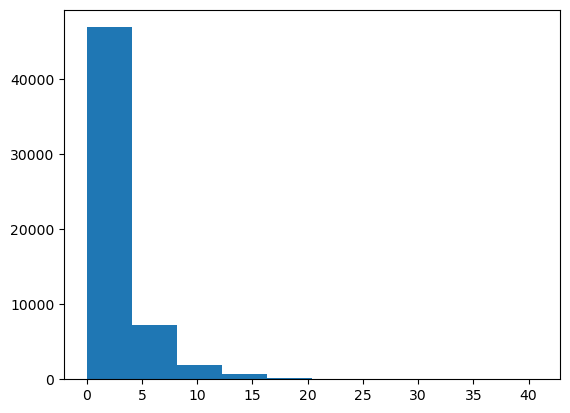

In [129]:
plt.hist(gene_score_total['score_total'])

# L1: 25 < x <= max in [5, 6] #about 80
# L2: 15 < x <= 25 in [4, 5] #about 477
# L3: 10 < x <= 15 in [3, 4] #about 1234
# L4: 5 < x <= 10 in [2, 3] #about 5678
# L5: 2 < x <= 5 in [1, 2] #about 14662
# L6: 0 < x <= 2 in [0, 1] #about 30323

In [130]:
cri1 = gene_score_total['score_total'] > 0
cri2 = gene_score_total['score_total'] <= 2
len(gene_score_total[cri1 & cri2])

30324

In [131]:
# L1 scaling raw score into [5, 6]
upper_b = 6
lower_b = 5
max_val = gene_score_total['score_total'].max()
min_val = 25
gene_score_total_L1 = gene_score_total[(gene_score_total['score_total'] <= max_val) & (gene_score_total['score_total'] > min_val)].reset_index().drop(['index'], axis = 1)

gene_score_total_L1['score'] = gene_score_total_L1['score_total'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [132]:
# L2 scaling raw score into [4, 5]
upper_b = 5
lower_b = 4
max_val = 25
min_val = 15
gene_score_total_L2 = gene_score_total[(gene_score_total['score_total'] <= max_val) & (gene_score_total['score_total'] > min_val)].reset_index().drop(['index'], axis = 1)

gene_score_total_L2['score'] = gene_score_total_L2['score_total'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [133]:
# L3 scaling raw score into [3, 4]
upper_b = 4
lower_b = 3
max_val = 15
min_val = 10
gene_score_total_L3 = gene_score_total[(gene_score_total['score_total'] <= max_val) & (gene_score_total['score_total'] > min_val)].reset_index().drop(['index'], axis = 1)

gene_score_total_L3['score'] = gene_score_total_L3['score_total'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [134]:
# L4 scaling raw score into [2, 3]
upper_b = 3
lower_b = 2
max_val = 10
min_val = 5
gene_score_total_L4 = gene_score_total[(gene_score_total['score_total'] <= max_val) & (gene_score_total['score_total'] > min_val)].reset_index().drop(['index'], axis = 1)

gene_score_total_L4['score'] = gene_score_total_L4['score_total'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [135]:
# L5 scaling raw score into [1, 2]
upper_b = 2
lower_b = 1
max_val = 5
min_val = 2
gene_score_total_L5 = gene_score_total[(gene_score_total['score_total'] <= max_val) & (gene_score_total['score_total'] > min_val)].reset_index().drop(['index'], axis = 1)

gene_score_total_L5['score'] = gene_score_total_L5['score_total'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [136]:
# L6 scaling raw score into [4, 5]
upper_b = 1
lower_b = 0
max_val = 2
min_val = 0
gene_score_total_L6 = gene_score_total[(gene_score_total['score_total'] <= max_val) & (gene_score_total['score_total'] > min_val)].reset_index().drop(['index'], axis = 1)

gene_score_total_L6['score'] = gene_score_total_L6['score_total'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [137]:
gene_score_total_v1 = pd.concat([gene_score_total_L1, gene_score_total_L2, gene_score_total_L3, gene_score_total_L4, gene_score_total_L5, gene_score_total_L6]).reset_index().drop(['index'], axis = 1)

(array([21615., 13481.,  8285.,  5047.,  2235.,   920.,   515.,   241.,
           90.,    25.]),
 array([1.91372600e-08, 6.00000017e-01, 1.20000002e+00, 1.80000001e+00,
        2.40000001e+00, 3.00000001e+00, 3.60000001e+00, 4.20000001e+00,
        4.80000000e+00, 5.40000000e+00, 6.00000000e+00]),
 <BarContainer object of 10 artists>)

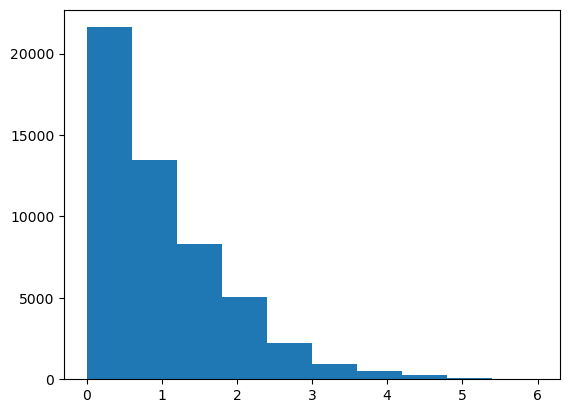

In [138]:
plt.hist(gene_score_total_v1['score'])

In [139]:
gene_score_total_v1.to_excel(r'C:\Users\edwar\Desktop\農藝\paper2\data collection\rna_layer_final.xlsx', index = False)

In [140]:
# excluding RNA Layer validation set
gene_score_total_exclude = gene_score_data_v1[['gene', 'score_individual', 'sig_flag_individual', 'nonsig_flag_individual']].merge(kim_2020_data_v1[['gene', 'score_kim2020', 'sig_flag_kim2020', 'nonsig_flag_kim2020']], on = ['gene'], how = 'outer').merge(rodrigues_2015_data[['gene', 'score_rodrigues2015', 'sig_flag_rodrigues2015', 'nonsig_flag_rodrigues2015']], on = ['gene'], how = 'outer').merge(tripathi_2016_data_v1[['gene', 'score_tripathi2016', 'sig_flag_tripathi2016', 'nonsig_flag_tripathi2016']], on = ['gene'], how = 'outer').merge(wang_2021_data[['gene', 'score_wang2021', 'sig_flag_wang2021', 'nonsig_flag_wang2021']], on = ['gene'], how = 'outer').merge(zhou_2020_data_v1[['gene', 'score_zhou2020', 'sig_flag_zhou2020', 'nonsig_flag_zhou2020']], on = ['gene'], how = 'outer').merge(chen_2016_data_v1[['gene', 'score_chen2016', 'sig_flag_chen2016', 'nonsig_flag_chen2016']], on = ['gene'], how = 'outer').merge(leisner_2017_data[['gene', 'score_leisner2017', 'sig_flag_leisner2017', 'nonsig_flag_leisner2017']], on = ['gene'], how = 'outer').merge(shi_2018_data_v1[['gene', 'score_shi2018', 'sig_flag_shi2018', 'nonsig_flag_shi2018']], on = ['gene'], how = 'outer').merge(le_2012_data_v1[['gene', 'score_le2012', 'sig_flag_le2012', 'nonsig_flag_le2012']], on = ['gene'], how = 'outer')
gene_score_total_exclude = gene_score_total_exclude[gene_score_total_exclude['gene'].str.contains('Glyma')].reset_index().drop(['index'], axis = 1)

In [141]:
gene_score_total_exclude['score_total'] = gene_score_total_exclude[['score_individual', 'score_kim2020', 'score_rodrigues2015', 'score_tripathi2016', 'score_wang2021', 'score_zhou2020', 'score_chen2016', 'score_leisner2017', 'score_shi2018', 'score_le2012']].sum(axis = 1)
gene_score_total_exclude['sigflag_total'] = gene_score_total_exclude[['sig_flag_individual', 'sig_flag_kim2020', 'sig_flag_rodrigues2015', 'sig_flag_tripathi2016', 'sig_flag_wang2021', 'sig_flag_zhou2020', 'sig_flag_chen2016', 'sig_flag_leisner2017', 'sig_flag_shi2018', 'sig_flag_le2012']].sum(axis = 1)
gene_score_total_exclude['nonsigflag_total'] = gene_score_total_exclude[['nonsig_flag_individual', 'nonsig_flag_kim2020', 'nonsig_flag_rodrigues2015', 'nonsig_flag_tripathi2016', 'nonsig_flag_wang2021', 'nonsig_flag_zhou2020', 'nonsig_flag_chen2016', 'nonsig_flag_leisner2017', 'nonsig_flag_shi2018', 'nonsig_flag_le2012']].sum(axis = 1)

In [142]:
gene_score_total_exclude

,gene,score_individual,sig_flag_individual,nonsig_flag_individual,score_kim2020,sig_flag_kim2020,nonsig_flag_kim2020,score_rodrigues2015,sig_flag_rodrigues2015,nonsig_flag_rodrigues2015,score_tripathi2016,sig_flag_tripathi2016,nonsig_flag_tripathi2016,score_wang2021,sig_flag_wang2021,nonsig_flag_wang2021,score_zhou2020,sig_flag_zhou2020,nonsig_flag_zhou2020,score_chen2016,sig_flag_chen2016,nonsig_flag_chen2016,score_leisner2017,sig_flag_leisner2017,nonsig_flag_leisner2017,score_shi2018,sig_flag_shi2018,nonsig_flag_shi2018,score_le2012,sig_flag_le2012,nonsig_flag_le2012,score_total,sigflag_total,nonsigflag_total
0,Glyma.05g039900,0.161962,2,0,NaN,NaN,NaN,NaN,NaN,NaN,0.127345,1,0,1.055032,1,0,0.807834,1,0,0.391703,1,0,0.001801,0,1,2.175267,1,0,0.762800,2.0,0.0,5.483744,9.0,1.0
1,Glyma.11g131900,0.115903,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002940,0,1,NaN,NaN,NaN,0.000954,0.0,2.0,0.119797,1.0,3.0
2,Glyma.13g322100,0.110120,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.096000,1,0,NaN,NaN,NaN,0.684193,1,0,NaN,NaN,NaN,2.000000,1,0,0.444204,0,1,0.005801,0.0,2.0,3.340318,4.0,3.0
3,Glyma.05g123700,0.111244,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.026026,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000599,0.0,2.0,2.137869,2.0,2.0
4,Glyma.09g163300,0.119740,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.498962,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006599,0.0,2.0,0.625300,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46708,Glyma.09g124300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001567,0.0,2.0,0.001567,0.0,2.0
46709,Glyma.06g278900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.314676,0.0,2.0,0.314676,0.0,2.0
46710,Glyma.06g278300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.428495,1.0,1.0,0.428495,1.0,1.0
46711,Glyma.10g073000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028481,0.0,2.0,0.028481,0.0,2.0


(array([3.6764e+04, 6.9910e+03, 1.8740e+03, 6.4100e+02, 2.4400e+02,
        1.1300e+02, 4.4000e+01, 2.2000e+01, 1.3000e+01, 7.0000e+00]),
 array([3.82745201e-08, 3.07856399e+00, 6.15712794e+00, 9.23569189e+00,
        1.23142558e+01, 1.53928198e+01, 1.84713837e+01, 2.15499477e+01,
        2.46285116e+01, 2.77070756e+01, 3.07856395e+01]),
 <BarContainer object of 10 artists>)

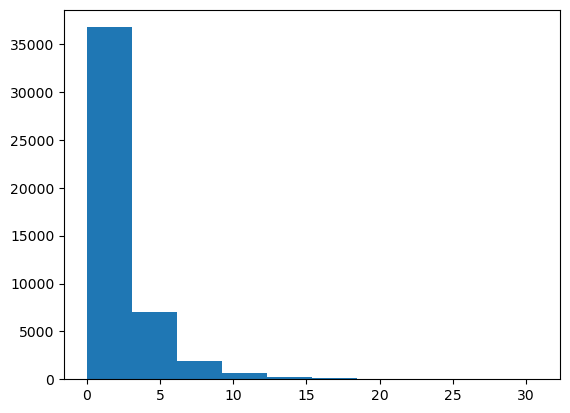

In [143]:
plt.hist(gene_score_total_exclude['score_total'])

In [144]:
gene_score_total_exclude.head()

,gene,score_individual,sig_flag_individual,nonsig_flag_individual,score_kim2020,sig_flag_kim2020,nonsig_flag_kim2020,score_rodrigues2015,sig_flag_rodrigues2015,nonsig_flag_rodrigues2015,score_tripathi2016,sig_flag_tripathi2016,nonsig_flag_tripathi2016,score_wang2021,sig_flag_wang2021,nonsig_flag_wang2021,score_zhou2020,sig_flag_zhou2020,nonsig_flag_zhou2020,score_chen2016,sig_flag_chen2016,nonsig_flag_chen2016,score_leisner2017,sig_flag_leisner2017,nonsig_flag_leisner2017,score_shi2018,sig_flag_shi2018,nonsig_flag_shi2018,score_le2012,sig_flag_le2012,nonsig_flag_le2012,score_total,sigflag_total,nonsigflag_total
0,Glyma.05g039900,0.161962,2,0,NaN,NaN,NaN,NaN,NaN,NaN,0.127345,1,0,1.055032,1,0,0.807834,1,0,0.391703,1,0,0.001801,0,1,2.175267,1,0,0.762800,2.0,0.0,5.483744,9.0,1.0
1,Glyma.11g131900,0.115903,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002940,0,1,NaN,NaN,NaN,0.000954,0.0,2.0,0.119797,1.0,3.0
2,Glyma.13g322100,0.110120,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.096000,1,0,NaN,NaN,NaN,0.684193,1,0,NaN,NaN,NaN,2.000000,1,0,0.444204,0,1,0.005801,0.0,2.0,3.340318,4.0,3.0
3,Glyma.05g123700,0.111244,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.026026,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000599,0.0,2.0,2.137869,2.0,2.0
4,Glyma.09g163300,0.119740,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.498962,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006599,0.0,2.0,0.625300,2.0,2.0


# L1: 20 < x <= max in [5, 6] #about 65
# L2: 12 < x <= 20 in [4, 5] #about 413
# L3: 7 < x <= 12 in [3, 4] #about 1711
# L4: 4 < x <= 7 in [2, 3] #about 4445
# L5: 2 < x <= 4 in [1, 2] #about 9888
# L6: 0 < x <= 2 in [0, 1] #about 30191

In [145]:
cri1 = gene_score_total_exclude['score_total'] > 0
cri2 = gene_score_total_exclude['score_total'] <= 2
len(gene_score_total_exclude[cri1 & cri2])

30193

In [146]:
# L1 scaling
upper_b = 6
lower_b = 5
max_val = gene_score_total_exclude['score_total'].max()
min_val = 20
gene_score_total_exclude_L1 = gene_score_total_exclude[(gene_score_total_exclude['score_total'] > min_val) & (gene_score_total_exclude['score_total'] <= max_val)].reset_index().drop(['index'], axis = 1)

gene_score_total_exclude_L1['score'] = gene_score_total_exclude_L1['score_total'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [147]:
# L2 scaling
upper_b = 5
lower_b = 4
max_val = 20
min_val = 12
gene_score_total_exclude_L2 = gene_score_total_exclude[(gene_score_total_exclude['score_total'] > min_val) & (gene_score_total_exclude['score_total'] <= max_val)].reset_index().drop(['index'], axis = 1)

gene_score_total_exclude_L2['score'] = gene_score_total_exclude_L2['score_total'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [148]:
# L3 scaling
upper_b = 4
lower_b = 3
max_val = 12
min_val = 7
gene_score_total_exclude_L3 = gene_score_total_exclude[(gene_score_total_exclude['score_total'] > min_val) & (gene_score_total_exclude['score_total'] <= max_val)].reset_index().drop(['index'], axis = 1)

gene_score_total_exclude_L3['score'] = gene_score_total_exclude_L3['score_total'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [149]:
# L4 scaling
upper_b = 3
lower_b = 2
max_val = 7
min_val = 4
gene_score_total_exclude_L4 = gene_score_total_exclude[(gene_score_total_exclude['score_total'] > min_val) & (gene_score_total_exclude['score_total'] <= max_val)].reset_index().drop(['index'], axis = 1)

gene_score_total_exclude_L4['score'] = gene_score_total_exclude_L4['score_total'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [150]:
# L5 scaling
upper_b = 2
lower_b = 1
max_val = 4
min_val = 2
gene_score_total_exclude_L5 = gene_score_total_exclude[(gene_score_total_exclude['score_total'] > min_val) & (gene_score_total_exclude['score_total'] <= max_val)].reset_index().drop(['index'], axis = 1)

gene_score_total_exclude_L5['score'] = gene_score_total_exclude_L5['score_total'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [151]:
# L6 scaling
upper_b = 1
lower_b = 0
max_val = 2
min_val = 0
gene_score_total_exclude_L6 = gene_score_total_exclude[(gene_score_total_exclude['score_total'] > min_val) & (gene_score_total_exclude['score_total'] <= max_val)].reset_index().drop(['index'], axis = 1)

gene_score_total_exclude_L6['score'] = gene_score_total_exclude_L6['score_total'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [152]:
gene_score_total_exclude_v1 = pd.concat([gene_score_total_exclude_L1, gene_score_total_exclude_L2, gene_score_total_exclude_L3, gene_score_total_exclude_L4, gene_score_total_exclude_L5, gene_score_total_exclude_L6]).reset_index().drop(['index'], axis = 1)

(array([2.2506e+04, 1.0756e+04, 5.4780e+03, 3.8250e+03, 1.9590e+03,
        1.3080e+03, 5.7300e+02, 2.2100e+02, 6.5000e+01, 2.2000e+01]),
 array([1.91372600e-08, 6.00000017e-01, 1.20000002e+00, 1.80000001e+00,
        2.40000001e+00, 3.00000001e+00, 3.60000001e+00, 4.20000001e+00,
        4.80000000e+00, 5.40000000e+00, 6.00000000e+00]),
 <BarContainer object of 10 artists>)

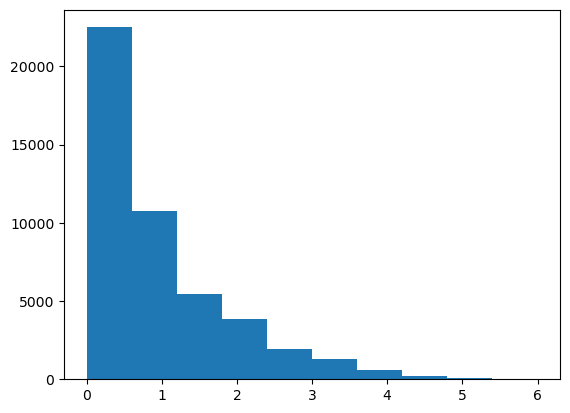

In [153]:
plt.hist(gene_score_total_exclude_v1['score'])

In [154]:
gene_score_total_exclude_v1.head()

,gene,score_individual,sig_flag_individual,nonsig_flag_individual,score_kim2020,sig_flag_kim2020,nonsig_flag_kim2020,score_rodrigues2015,sig_flag_rodrigues2015,nonsig_flag_rodrigues2015,score_tripathi2016,sig_flag_tripathi2016,nonsig_flag_tripathi2016,score_wang2021,sig_flag_wang2021,nonsig_flag_wang2021,score_zhou2020,sig_flag_zhou2020,nonsig_flag_zhou2020,score_chen2016,sig_flag_chen2016,nonsig_flag_chen2016,score_leisner2017,sig_flag_leisner2017,nonsig_flag_leisner2017,score_shi2018,sig_flag_shi2018,nonsig_flag_shi2018,score_le2012,sig_flag_le2012,nonsig_flag_le2012,score_total,sigflag_total,nonsigflag_total,score
0,Glyma.06g154400,4.266194,6,0,4.561853,1,0,3.568934,1,0,0.822809,1,0,1.836406,1,0,NaN,NaN,NaN,1.481282,1,0,0.008873,1,0,2.615471,1,0,4.099220,2.0,0.0,23.261043,15.0,0.0,5.302350
1,Glyma.06g248900,3.429289,10,0,3.545640,1,0,0.697926,1,0,0.972343,1,0,6.000000,1,0,0.156669,1,0,2.368852,1,0,0.007053,0,1,4.077786,1,0,2.002691,2.0,0.0,23.258250,19.0,1.0,5.302091
2,Glyma.12g149100,3.999288,9,0,4.386931,1,0,0.603691,1,0,3.571205,1,0,0.759918,1,0,NaN,NaN,NaN,1.933510,1,0,0.003723,0,1,3.483614,1,0,1.743978,2.0,0.0,20.485857,17.0,1.0,5.045047
3,Glyma.12g221500,3.553189,11,0,3.838565,1,0,0.850625,1,0,2.926320,1,0,2.459262,1,0,0.148924,1,0,3.781446,1,0,0.005665,0,1,3.790016,1,0,4.916125,2.0,0.0,26.270136,20.0,1.0,5.581341
4,Glyma.13g279900,4.302588,8,0,3.771233,1,0,1.284644,1,0,1.233600,1,0,6.000000,1,0,NaN,NaN,NaN,3.494614,1,0,0.005758,0,1,3.970704,1,0,4.349258,2.0,0.0,28.412401,16.0,1.0,5.779963


In [155]:
gene_score_total_exclude_v1.to_excel(r'C:\Users\edwar\Desktop\農藝\paper2\data collection\rna_layer_final_exclude.xlsx', index = False)